# Start


In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import (
    anderson,
    iqr,
    jarque_bera,
    kstest,
    kurtosis,
    probplot,
    shapiro,
    skew,
    zscore,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (
    RFE,
    SelectFromModel,
    SelectKBest,
    VarianceThreshold,
    chi2,
    f_classif,
    f_regression,
    mutual_info_classif,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    QuantileTransformer,
    StandardScaler,
)
from sklearn.svm import SVR, LinearSVC

In [2]:
file_path: str = "../data/raw"
files: tuple[str, ...] = ("connections", "devices", "processes", "profiles")

dataset: dict[str, pd.DataFrame] = {}
for file in files:
    dataset[file] = pd.read_csv(f"{file_path}/{file}.csv", sep="\t")
    dataset[file] = dataset[file].drop_duplicates()

Merging "connections" and "processes" on "ts" "imei"


In [3]:
df = pd.merge(dataset["connections"], dataset["processes"], on=["imei", "ts", "mwra"])
df["ts"] = pd.to_datetime(df.ts)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14929 entries, 0 to 14928
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ts                          14929 non-null  datetime64[ns]
 1   imei                        14929 non-null  int64         
 2   mwra                        14929 non-null  float64       
 3   c.dogalize                  14929 non-null  float64       
 4   c.android.gm                14929 non-null  float64       
 5   c.android.youtube           14929 non-null  float64       
 6   c.android.chrome            14929 non-null  float64       
 7   c.katana                    14929 non-null  float64       
 8   c.raider                    14929 non-null  float64       
 9   c.android.vending           14929 non-null  float64       
 10  c.UCMobile.x86              14929 non-null  float64       
 11  c.updateassist              14929 non-null  float64   

In [4]:
devices = dataset["devices"]["imei"]
print(f"Number of duplicated imei: {int(devices.duplicated().sum())}")

Number of duplicated imei: 2423


In [5]:
profiles = dataset["profiles"]["imei"]
print(f"Number of duplicated imei: {int(profiles.duplicated().sum())}")

Number of duplicated imei: 2073


-   If we want to merge tables "devices" and "profiles", then we have problem.
-   These tables contains duplicated data for imei's, and since these tables don't have column "ts", we can't join them effectively.
-   If we join them we would perform some cross joins in data and we don't want that.
-   Therefore we are only going to join "connections" and "processes"


# 2.1


## A


### **Zadanie:** Dáta si rozdeľte na trénovaciu a testovaciu množinu podľa vami preddefinovaného pomeru. Ďalej pracujte len s trénovacím datasetom.


In [6]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

## B


### **Zadanie:** Transformujte dáta na vhodný formát pre ML t.j. jedno pozorovanie musí byť opísané jedným riadkom a každý atribút musí byť v numerickom formáte (encoding). Iteratívne integrujte aj kroky v predspracovaní dát z prvej fázy (missing values, outlier detection) ako celok.


In [7]:
duplicate_ts = train_data.duplicated(subset="ts").any()
print(f"Are there any duplicate timestamps? {duplicate_ts}")

Are there any duplicate timestamps? False


-   There are no duplicates in datetime, therefore every observation is in one row


In [8]:
train_data.dtypes.value_counts()

float64           31
datetime64[ns]     1
int64              1
Name: count, dtype: int64

-   All columns are in numerical format


In [9]:
null_counts = train_data.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_counts

Series([], dtype: int64)

-   There are no missing values


Graph showing the boxplot and outliers of the dataset.


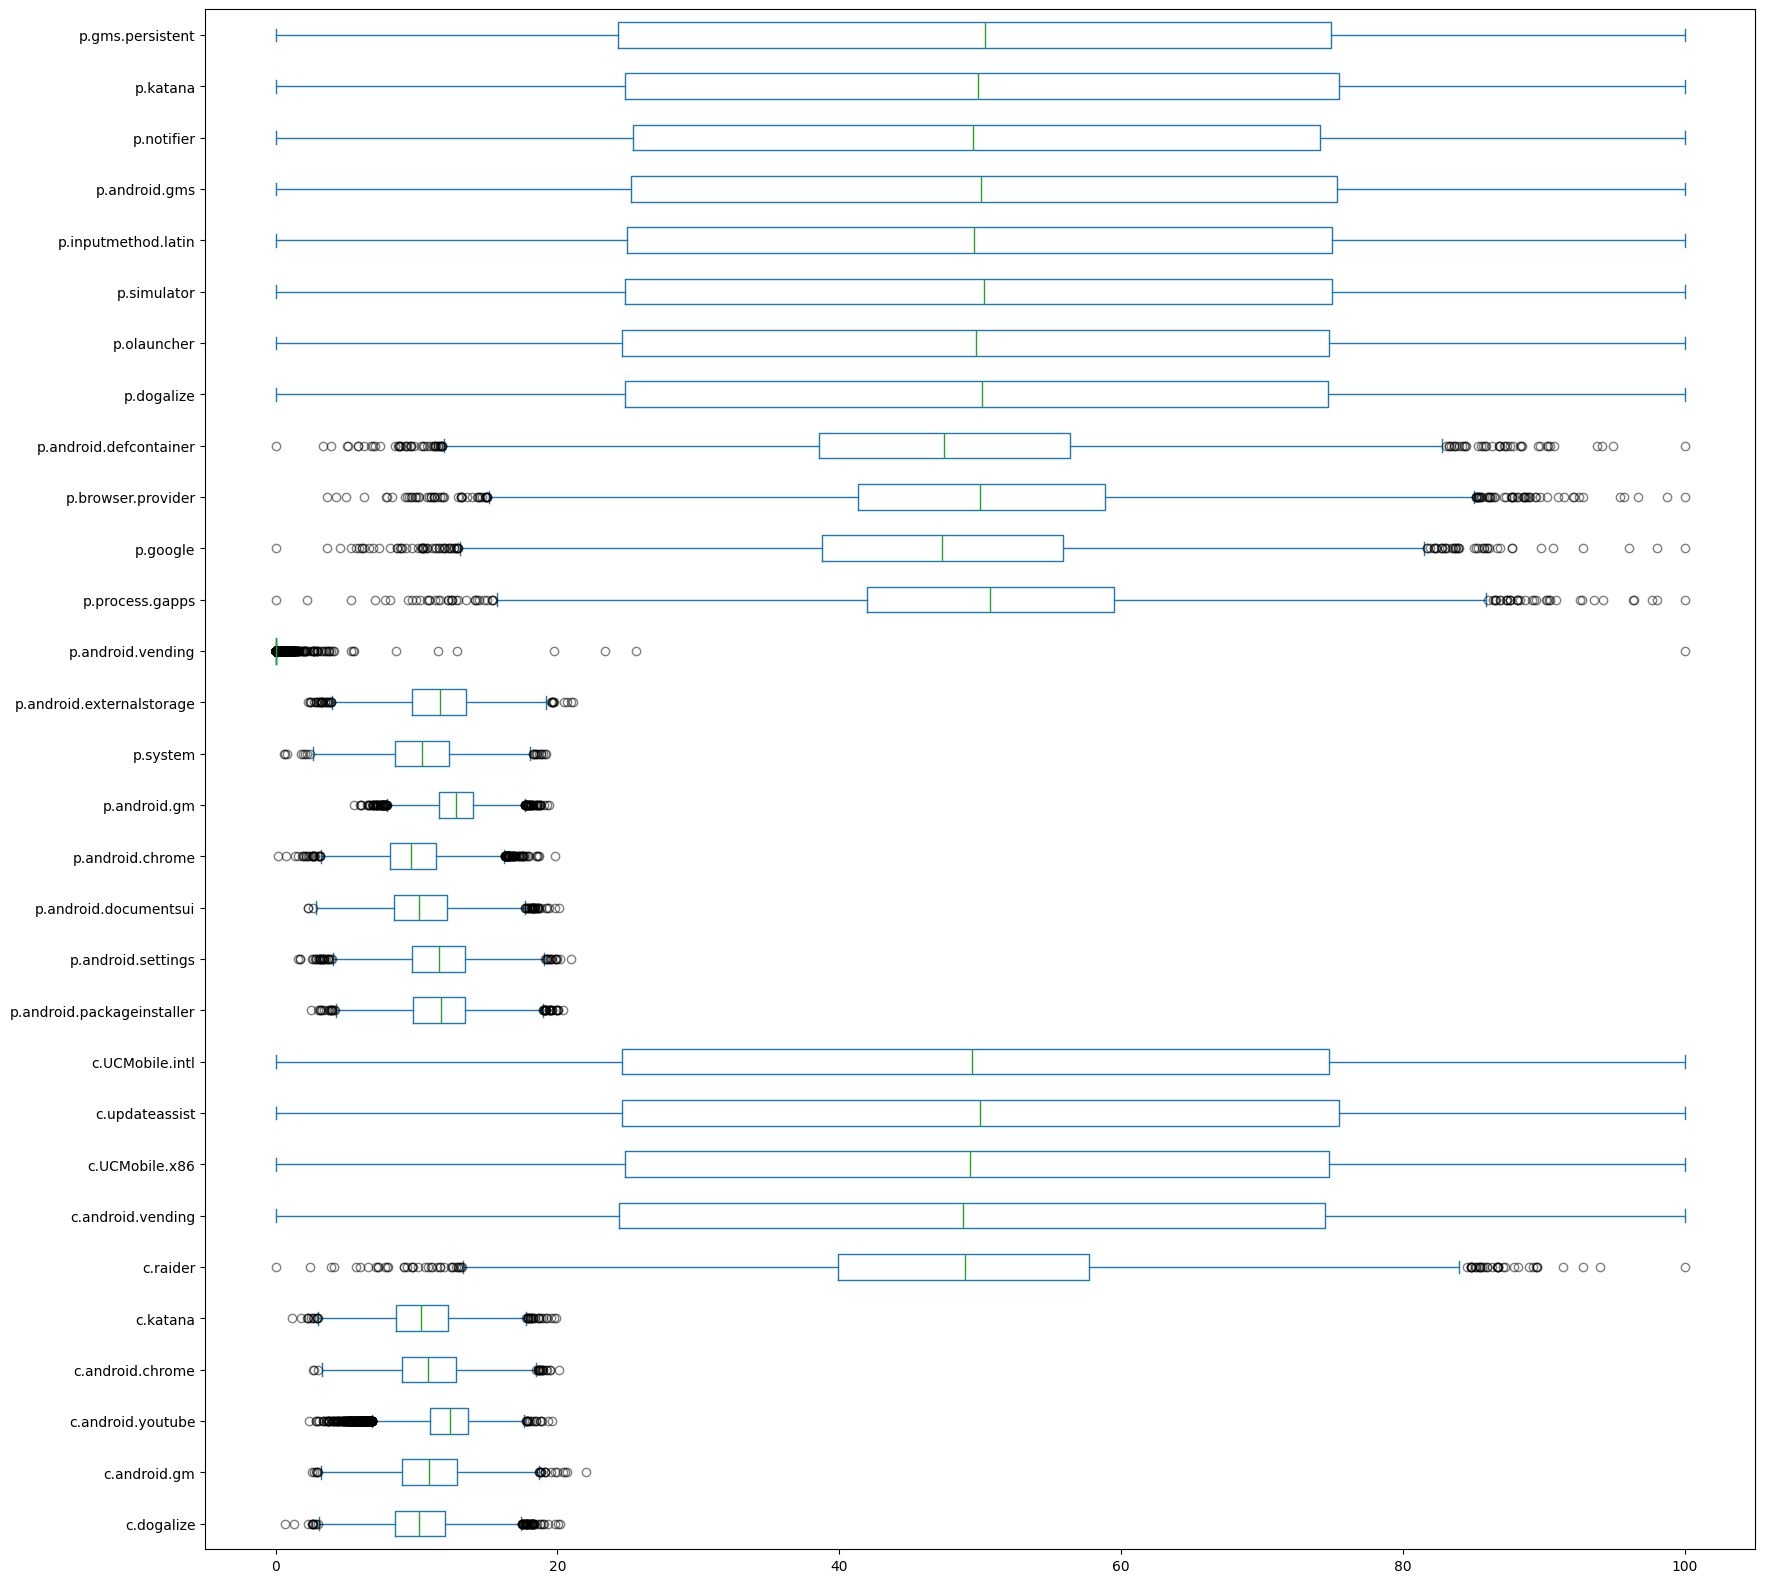

In [10]:
train_data.iloc[:, 3:].plot(
    kind="box", vert=False, figsize=(20, 20), flierprops=dict(marker="o", color="r", alpha=0.5)
)
plt.show()

Using Z-score (3) to detect outliers.


In [11]:
number_of_rows_before = train_data.shape[0]
print(f"Number of rows before removing outliers: {number_of_rows_before}")

train_data = train_data[(np.abs(zscore(train_data.iloc[:, 3:])) < 3).all(axis=1)]

number_of_rows_after = train_data.shape[0]
print(f"Number of rows after removing outliers: {number_of_rows_after}")
print(f"Number of rows removed: {number_of_rows_before - number_of_rows_after}")
print(
    f"Percentage of rows removed: {(number_of_rows_before - number_of_rows_after) / number_of_rows_before * 100:.2f}%"
)

Number of rows before removing outliers: 11943
Number of rows after removing outliers: 11466
Number of rows removed: 477
Percentage of rows removed: 3.99%


-   Removing 4% of the is ok, therefore we are not going to use methods to replace outliers


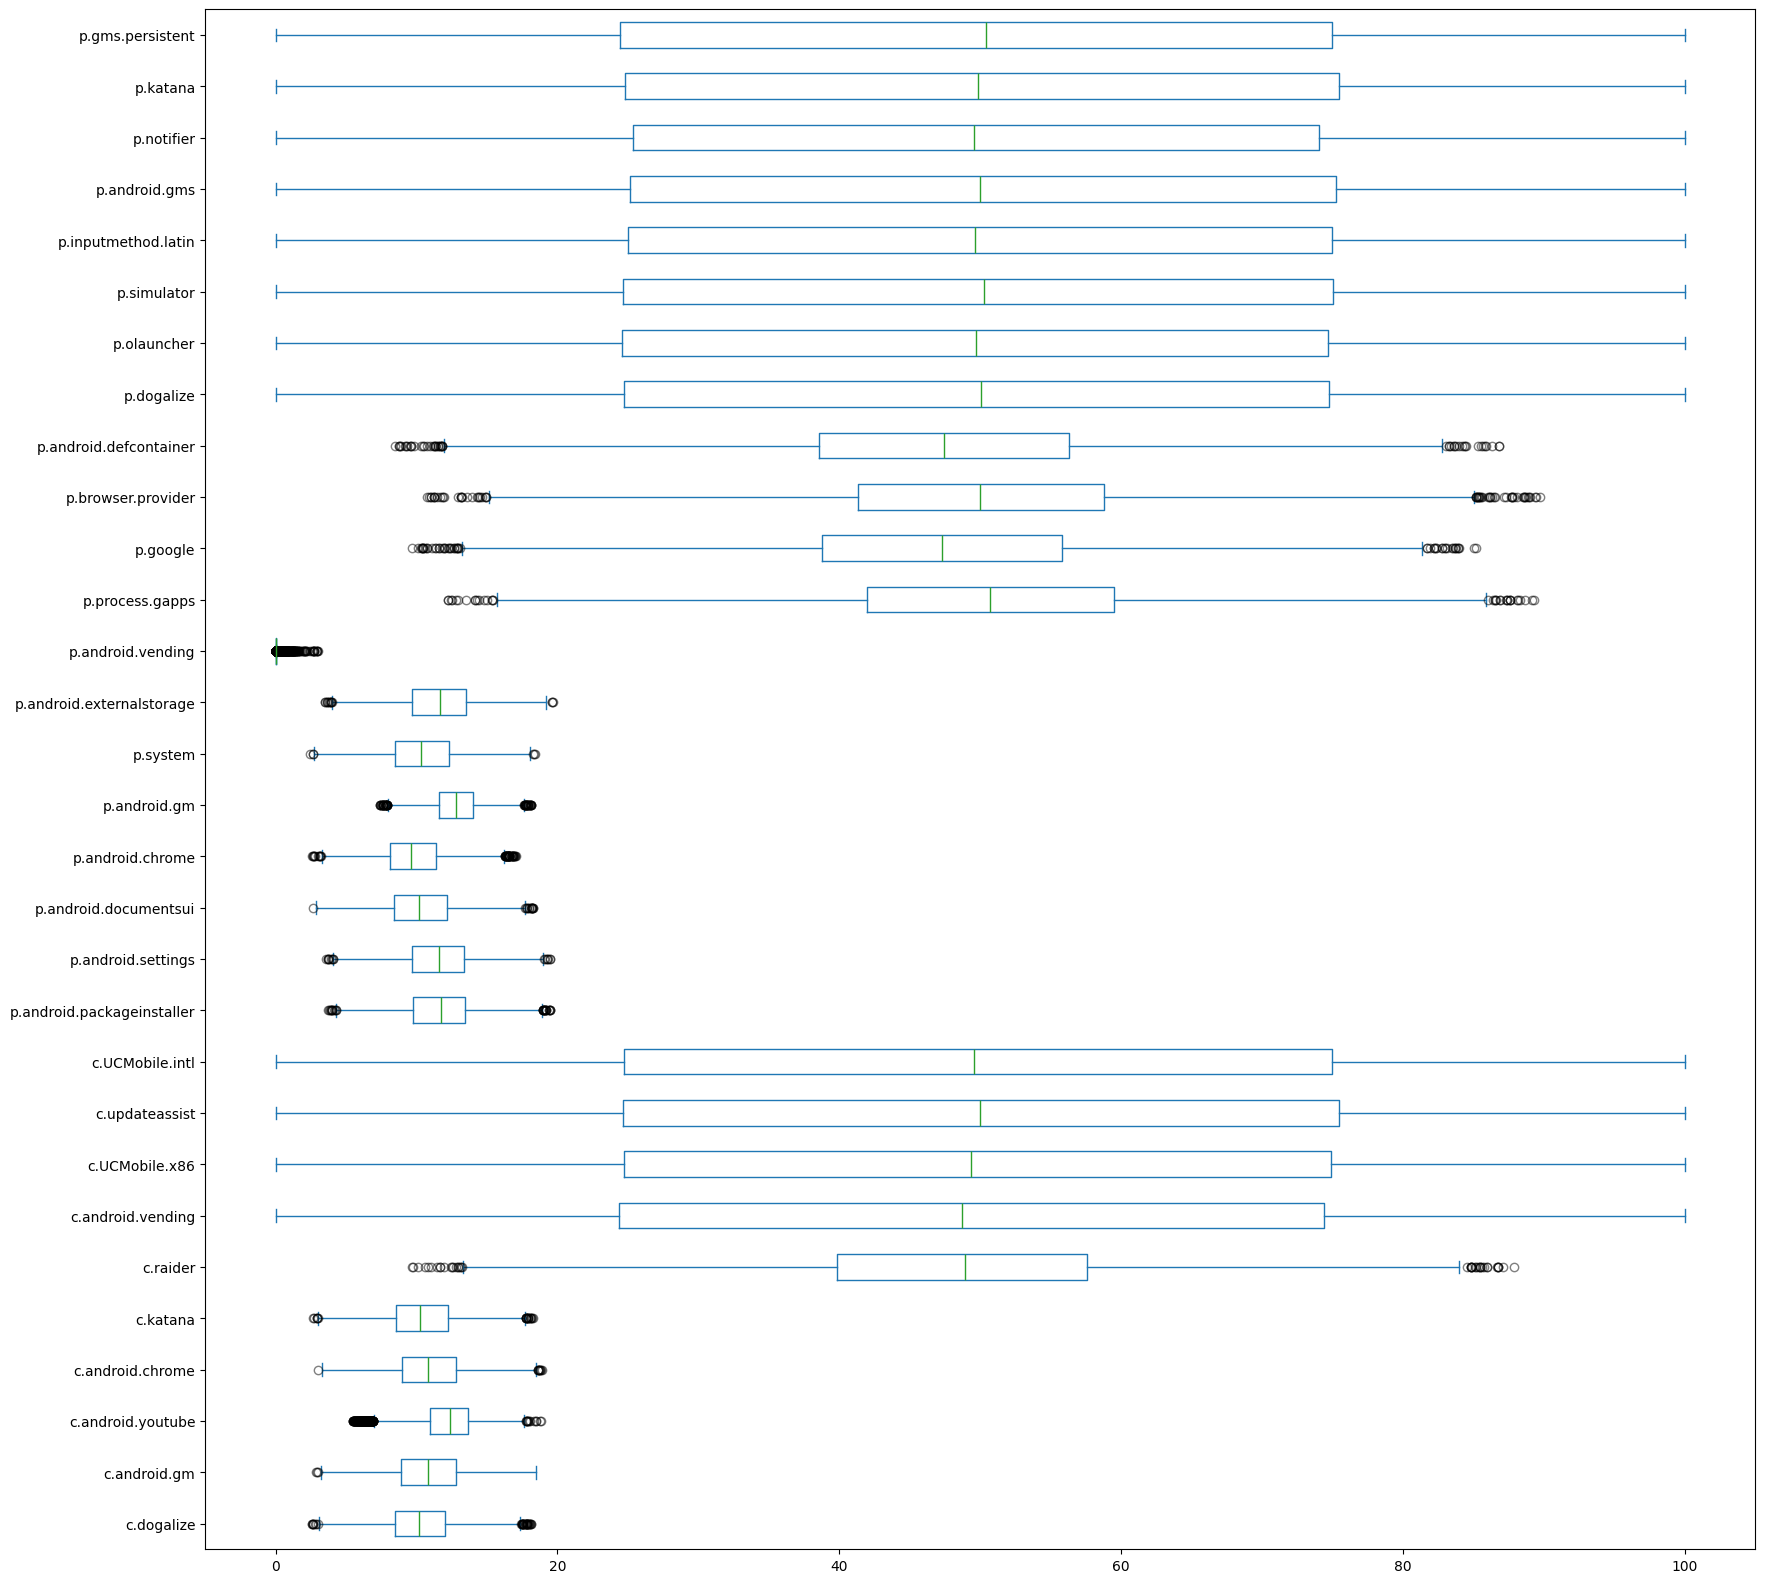

In [12]:
train_data.iloc[:, 3:].plot(
    kind="box", vert=False, figsize=(20, 20), flierprops=dict(marker="o", color="r", alpha=0.5)
)
plt.show()

More in-depth analysis of **"p.android.vending"**


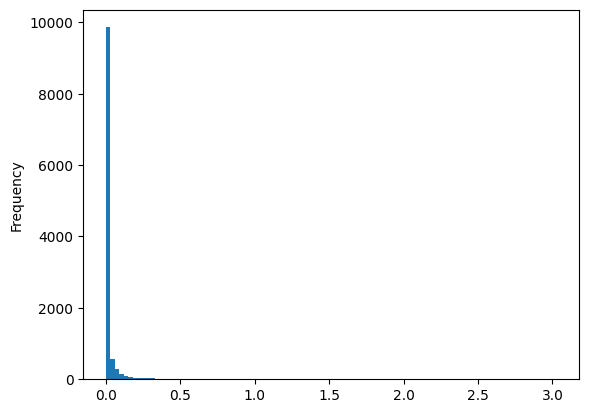

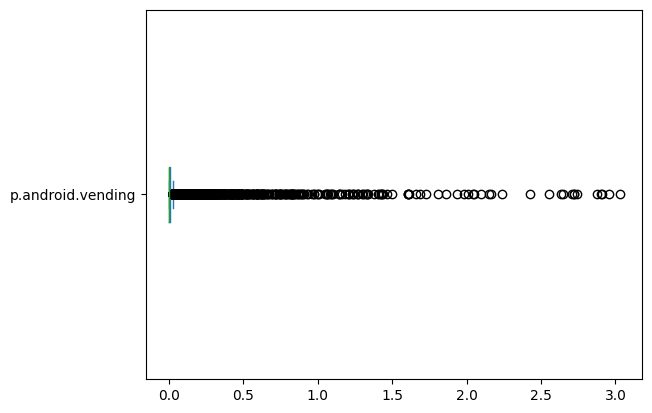

In [13]:
train_data["p.android.vending"].plot(kind="hist", bins=100)
plt.show()
train_data["p.android.vending"].plot(kind="box", vert=False)
plt.show()

-   We can see that is that logarithmic scale, that's why it has so many outliers


In [14]:
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * iqr(a)
    upper = a.quantile(0.75) + 1.5 * iqr(a)

    return a[(a > upper) | (a < lower)]


train_data_copy = train_data.copy()
outliers = train_data_copy[["p.android.vending"]].apply(identify_outliers)
train_data_copy = train_data_copy.drop(outliers.index)
print(f"Number of outliers: {train_data_copy[["p.android.vending"]].apply(identify_outliers).count().values[0]}")
print(
    f"Percentage of outliers: {train_data_copy[["p.android.vending"]].apply(identify_outliers).count().values[0] / train_data_copy.shape[0] * 100:.2f}%"
)

Number of outliers: 1183
Percentage of outliers: 12.23%


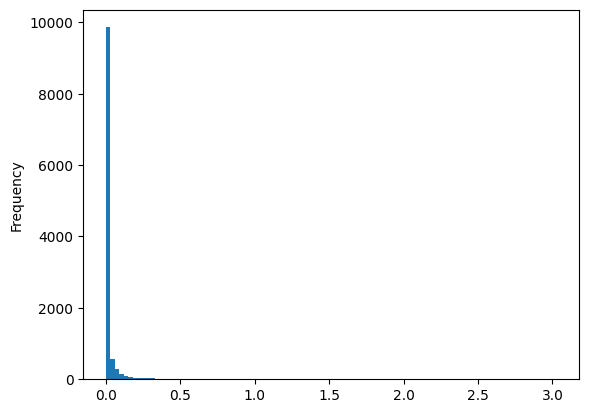

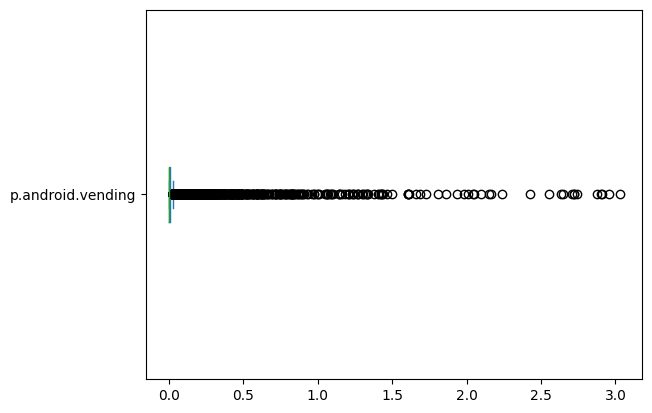

In [15]:
train_data["p.android.vending"].plot(kind="hist", bins=100)
plt.show()
train_data["p.android.vending"].plot(kind="box", vert=False)
plt.show()

-   In column **'p.android.vending'** there were too many outliers
-   We tried to remove them using 25% and 75% quantiles, but there was almost no noticeable difference
-   Using this we would remove 1183 (12.23%) rows which is quite substantial amount, therefore we decided not ot manipulate with outliers in this column


## C


### **Zadanie:** Transformujte atribúty dát pre strojové učenie podľa dostupných techník minimálne: scaling (2 techniky), transformers (2 techniky) a ďalšie. Cieľom je aby ste testovali efekty a vhodne kombinovali v dátovom pipeline (od časti 2.3 a v 3. fáze).


### Defining variables (only scaling X)


In [16]:
X = train_data.drop(columns=["mwra", "ts", "imei"])
y = train_data["mwra"]
all_columns = X.columns

### Showing the distribution of the data before scaling/transforming


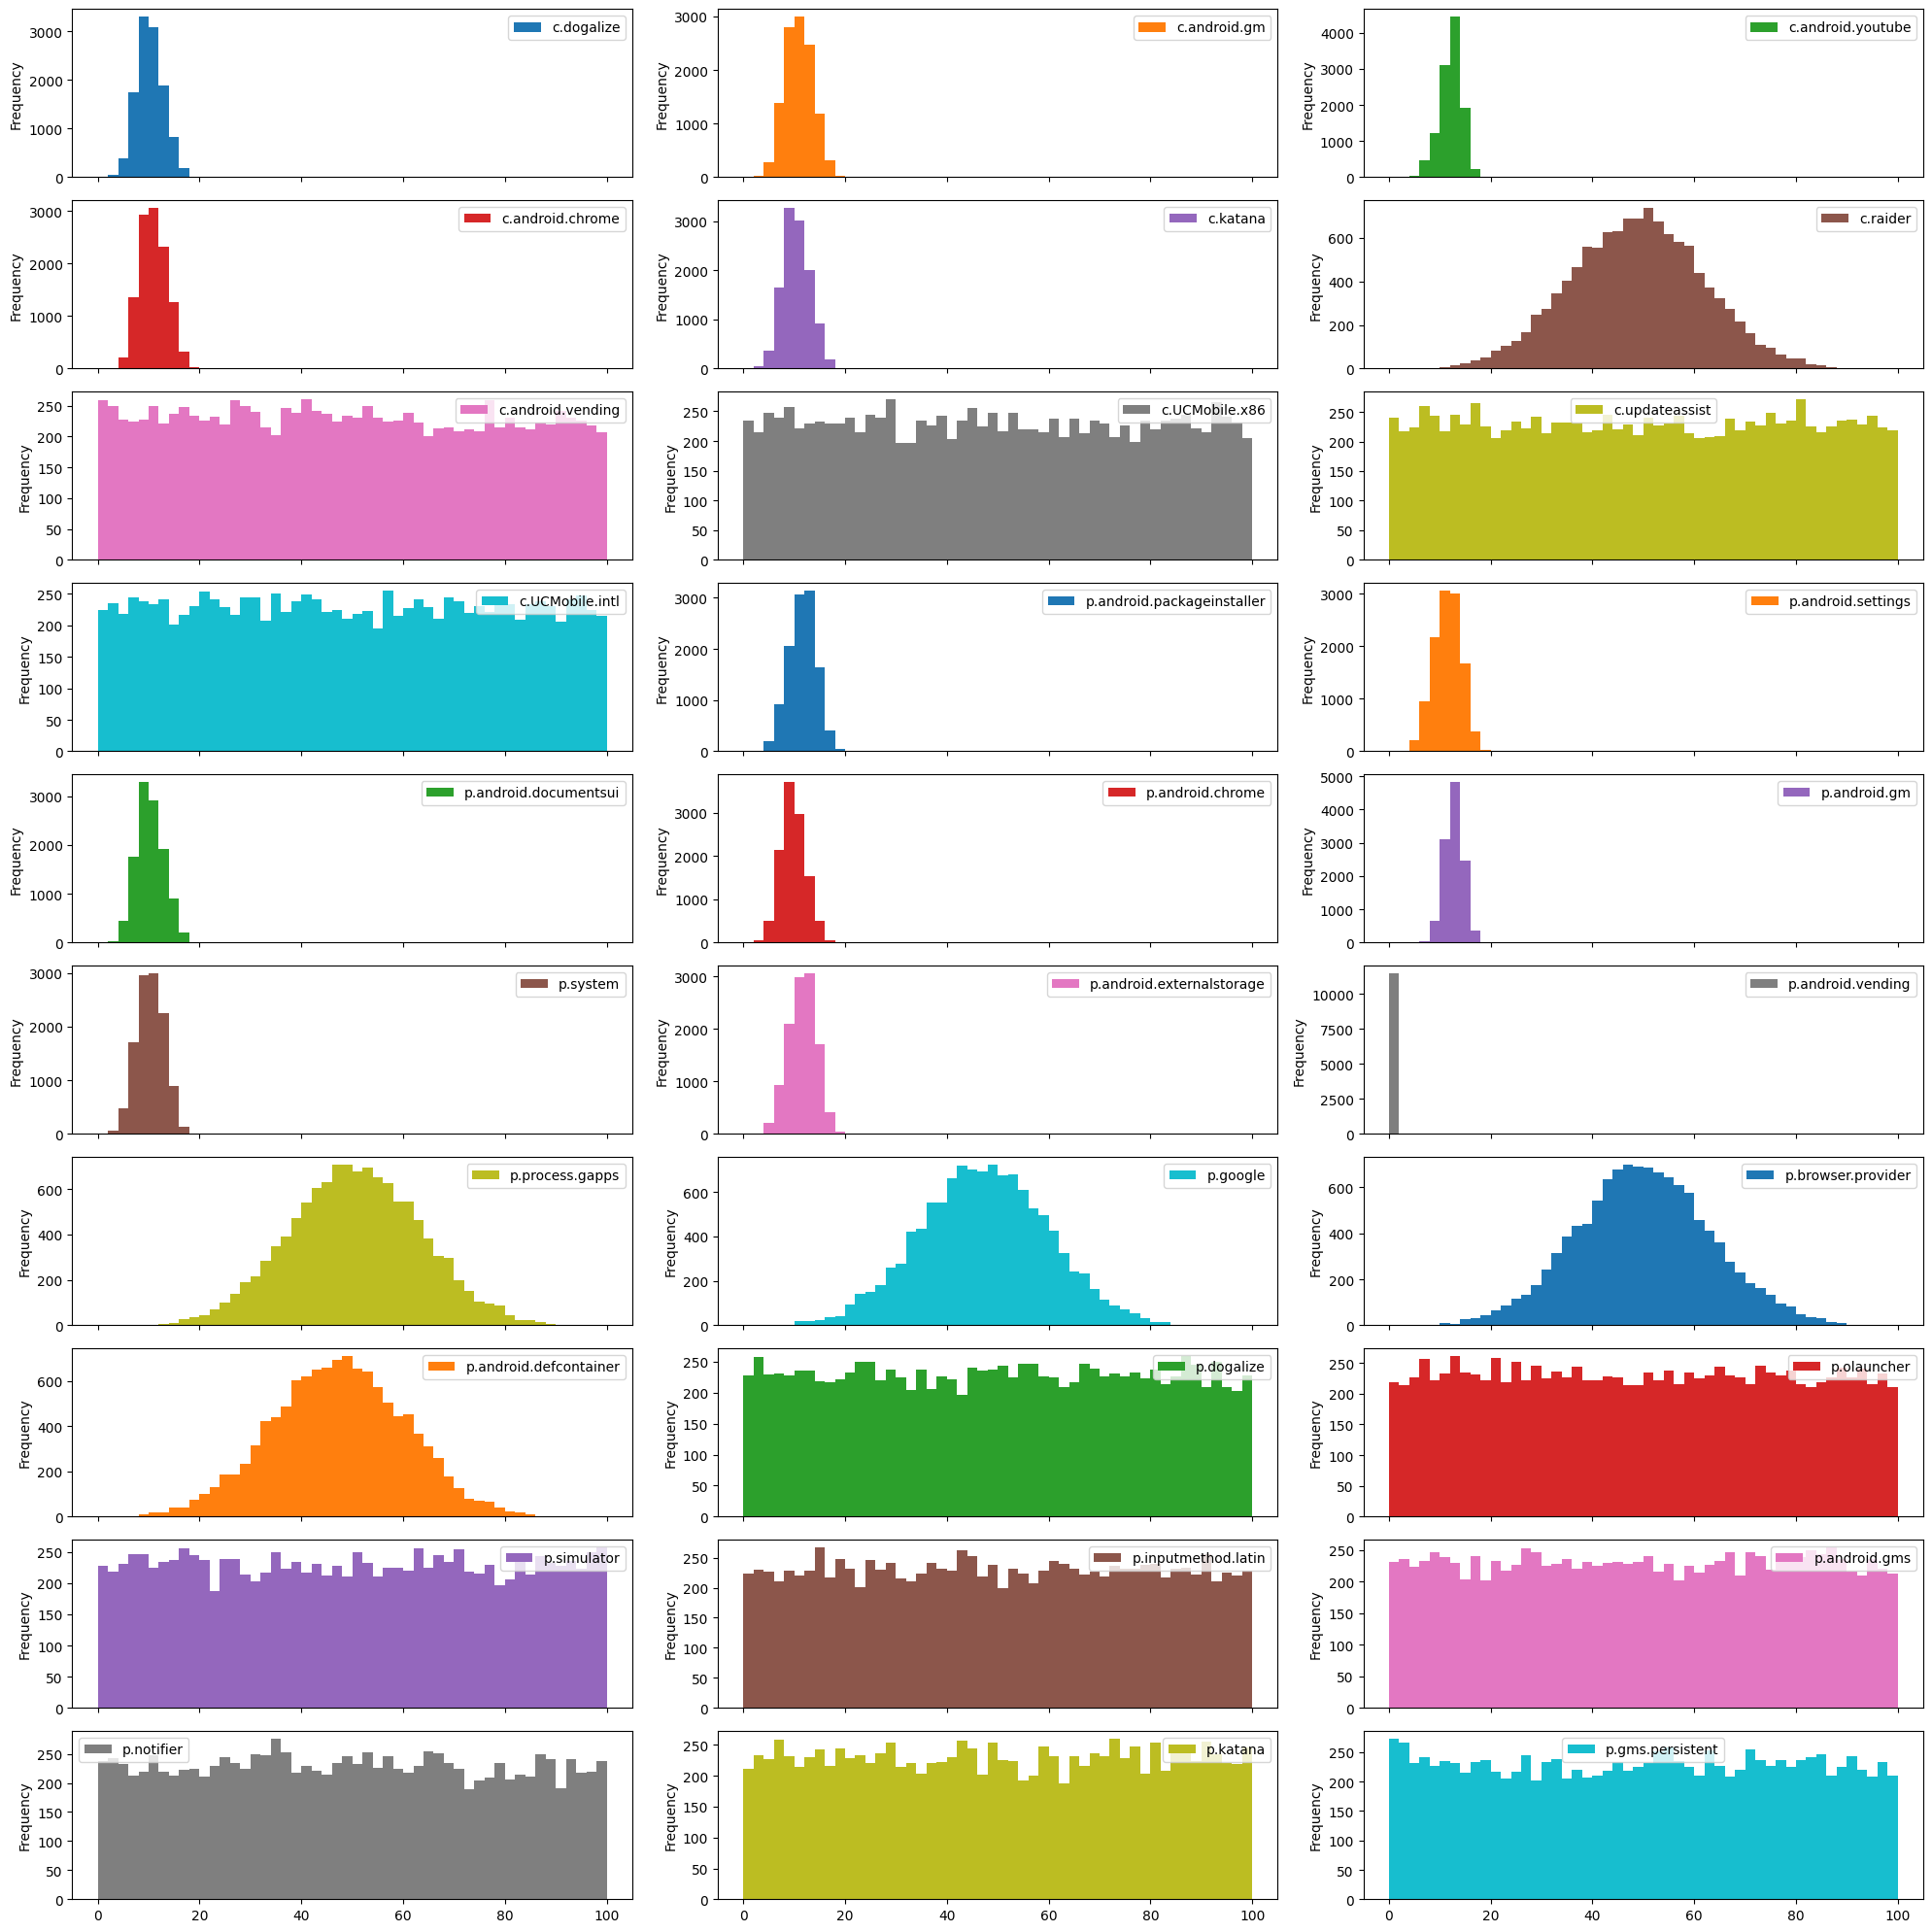

In [17]:
X.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

### Using MinMaxScaler


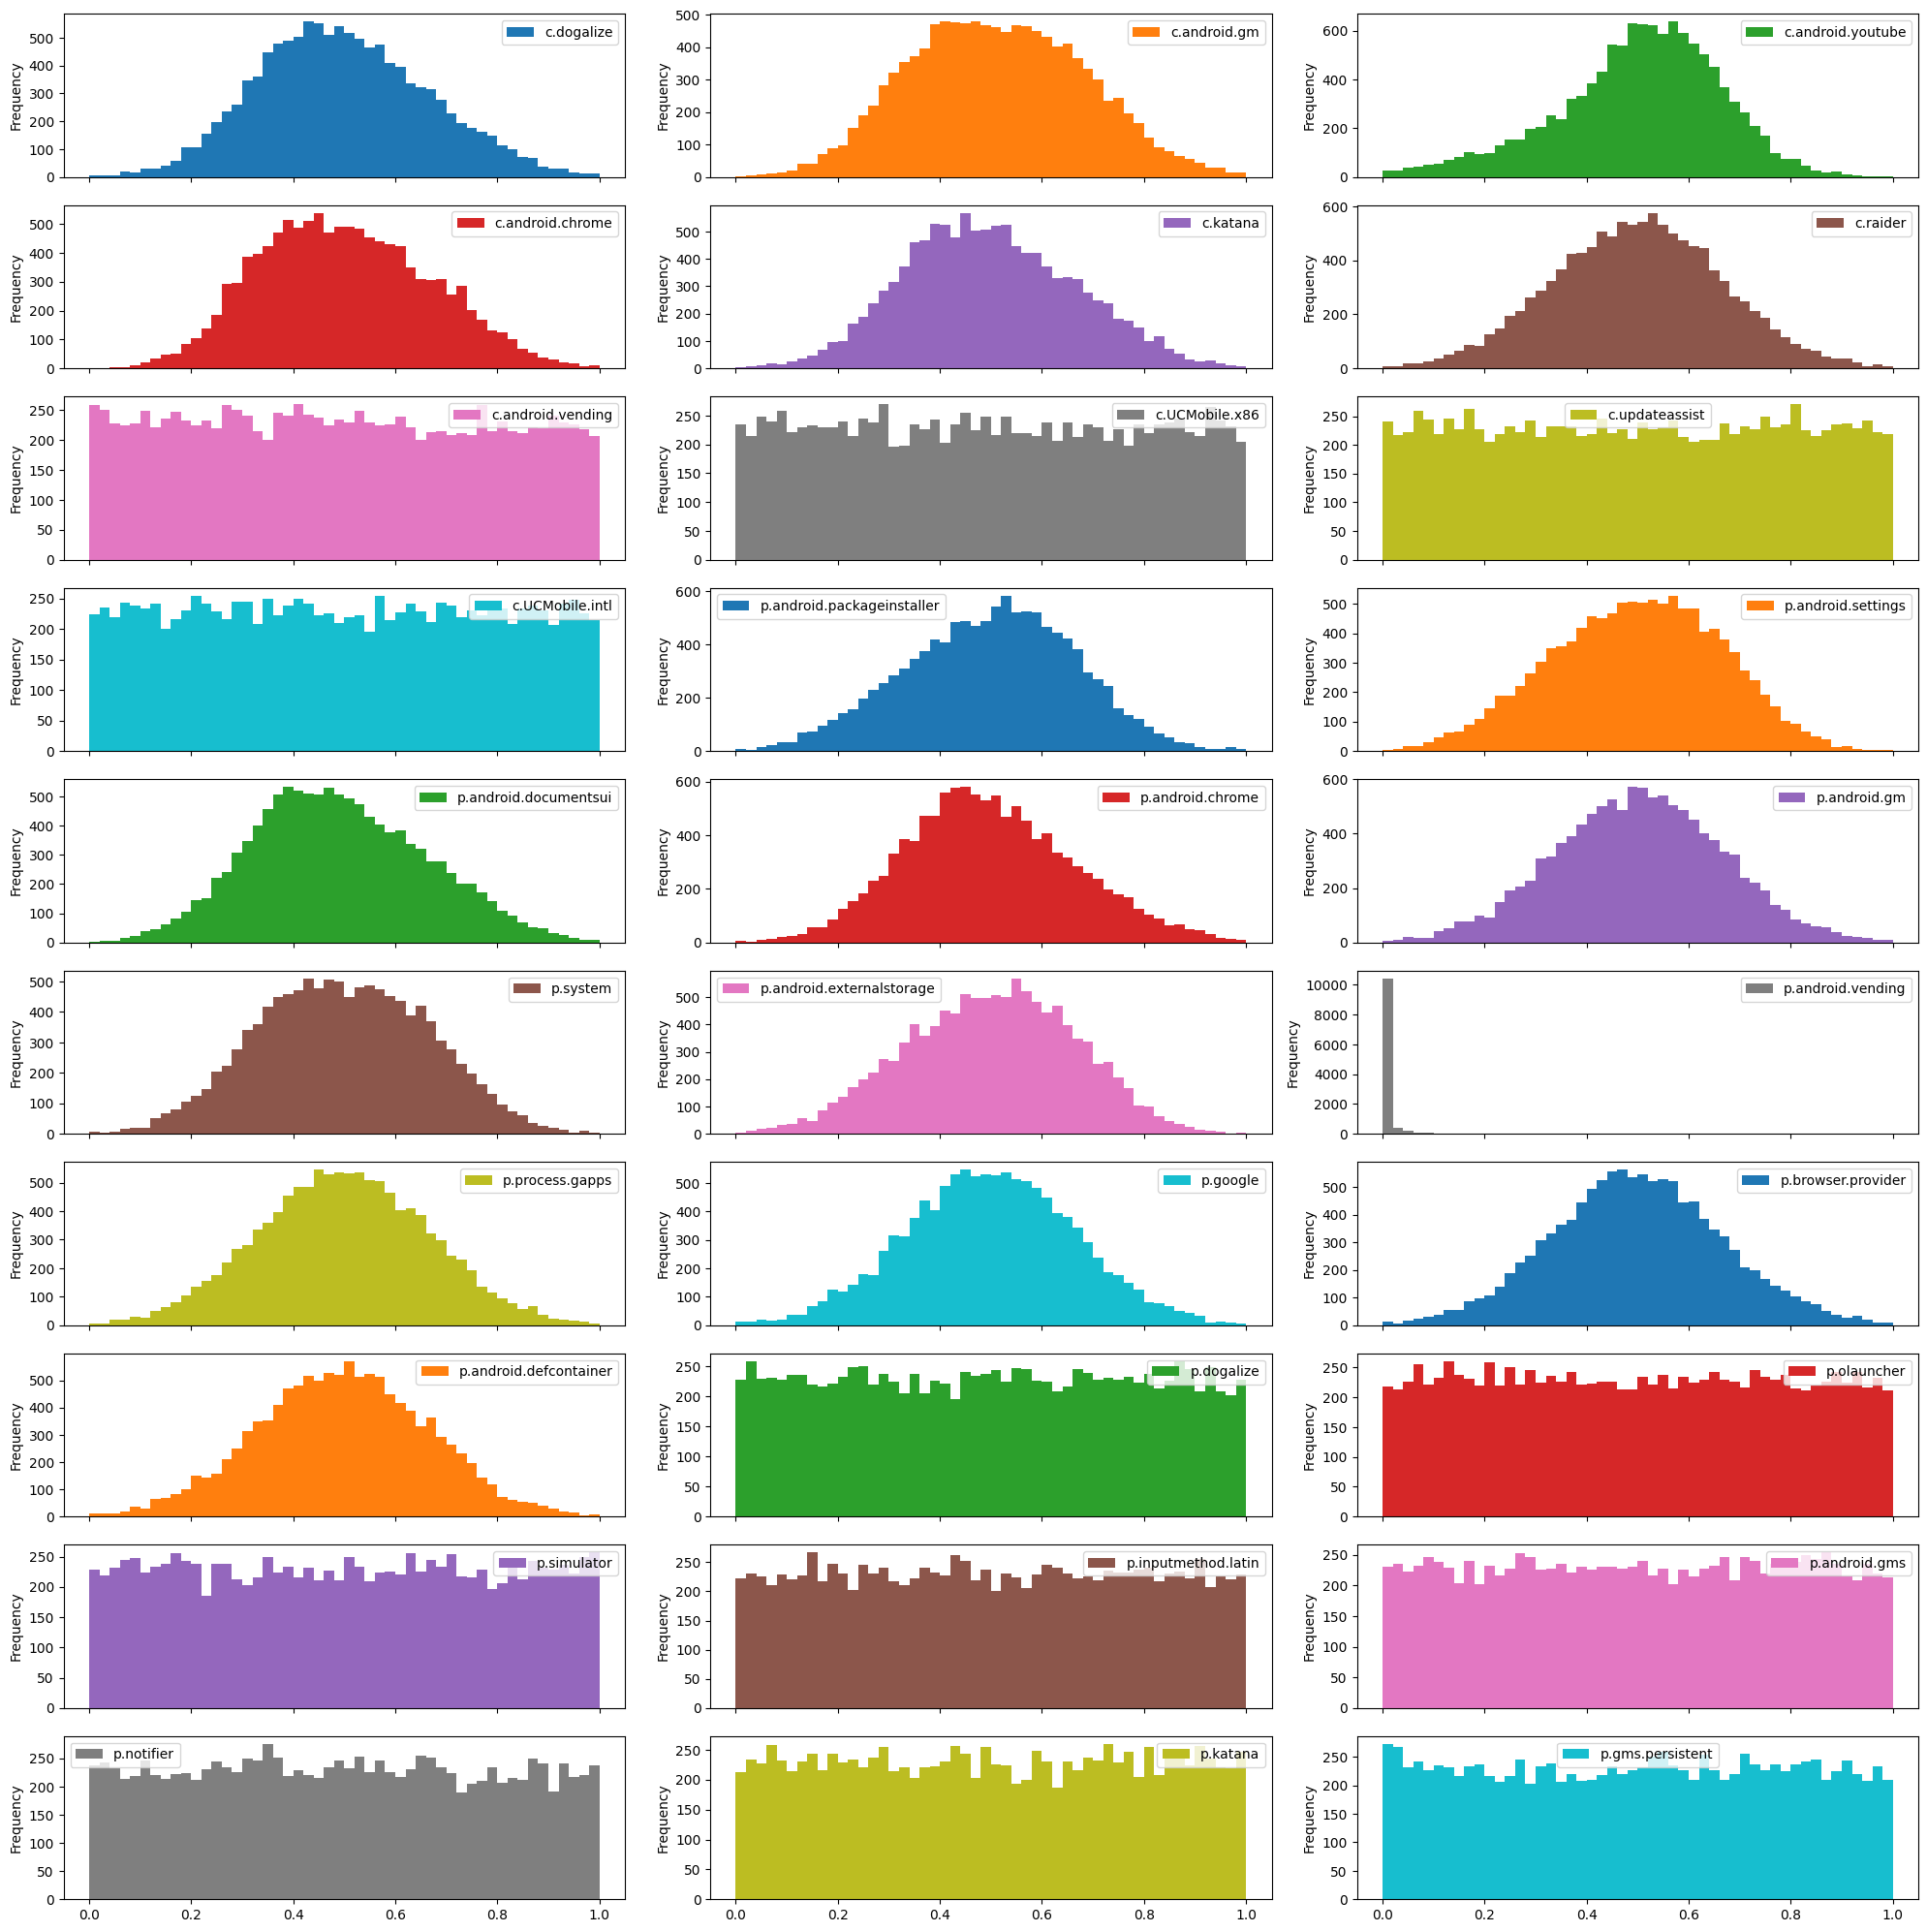

In [18]:
scaler = MinMaxScaler()
normalized_data = X.copy()
normalized_data[all_columns] = scaler.fit_transform(normalized_data[all_columns])

normalized_data.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

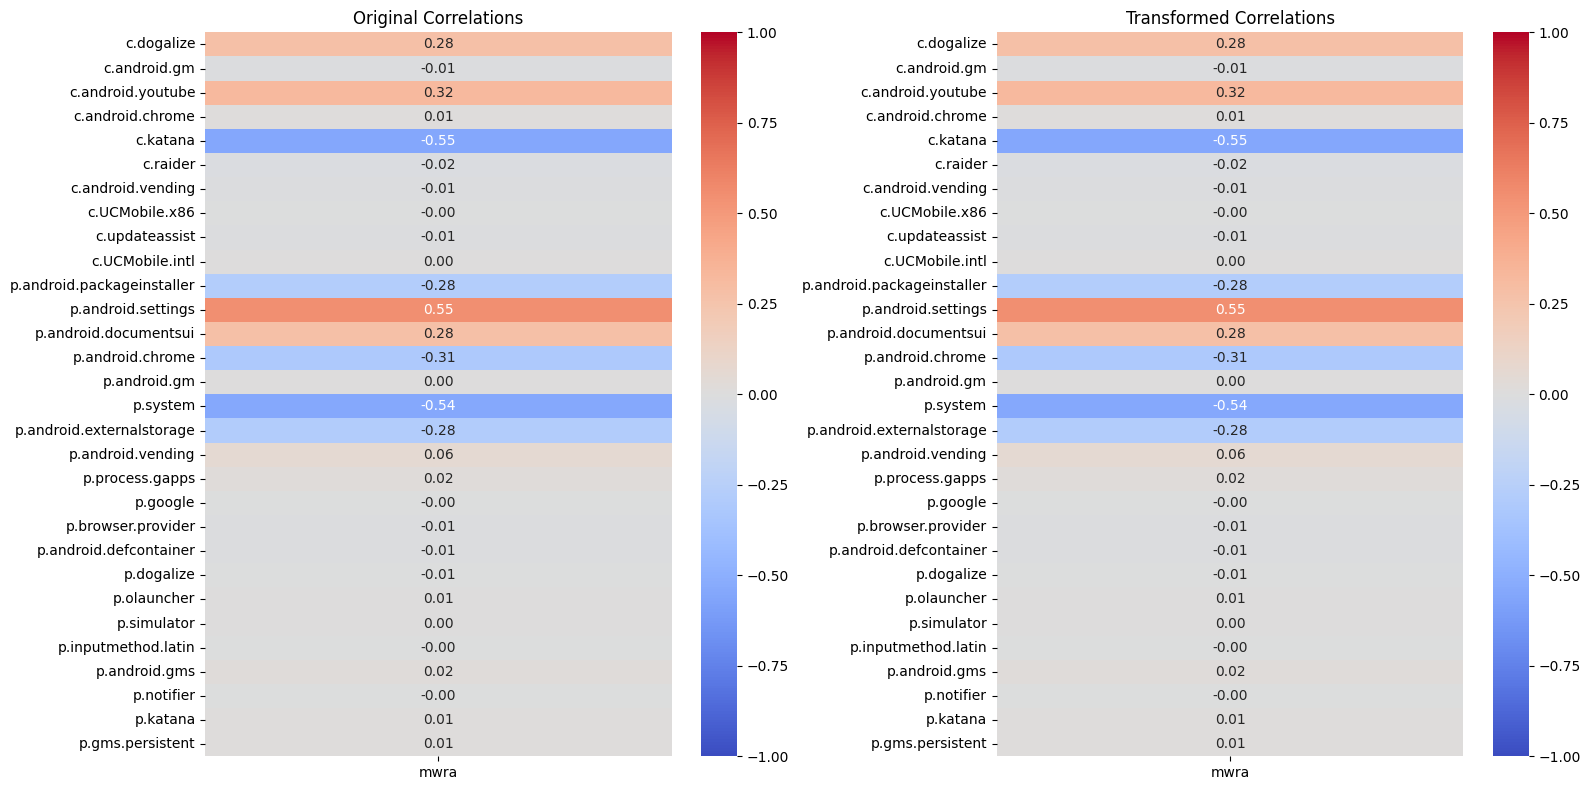

In [19]:
feature_columns = normalized_data.columns.tolist()

# Original correlations
combined_df_orig = pd.concat([X, train_data["mwra"]], axis=1).dropna()
corr_orig = combined_df_orig.corr(method="pearson")
filtered_corr_orig = corr_orig.loc[feature_columns, ["mwra"]]

# Transformed correlations
combined_df_trans = pd.concat([normalized_data, train_data["mwra"]], axis=1).dropna()
corr_trans = combined_df_trans.corr(method="pearson")
filtered_corr_trans = corr_trans.loc[feature_columns, ["mwra"]]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot original correlations
sns.heatmap(
    filtered_corr_orig,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax1,
)
ax1.set_title("Original Correlations")

# Plot transformed correlations
sns.heatmap(
    filtered_corr_trans,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax2,
)
ax2.set_title("Transformed Correlations")
plt.tight_layout()
plt.show()

### Using StandardScaler


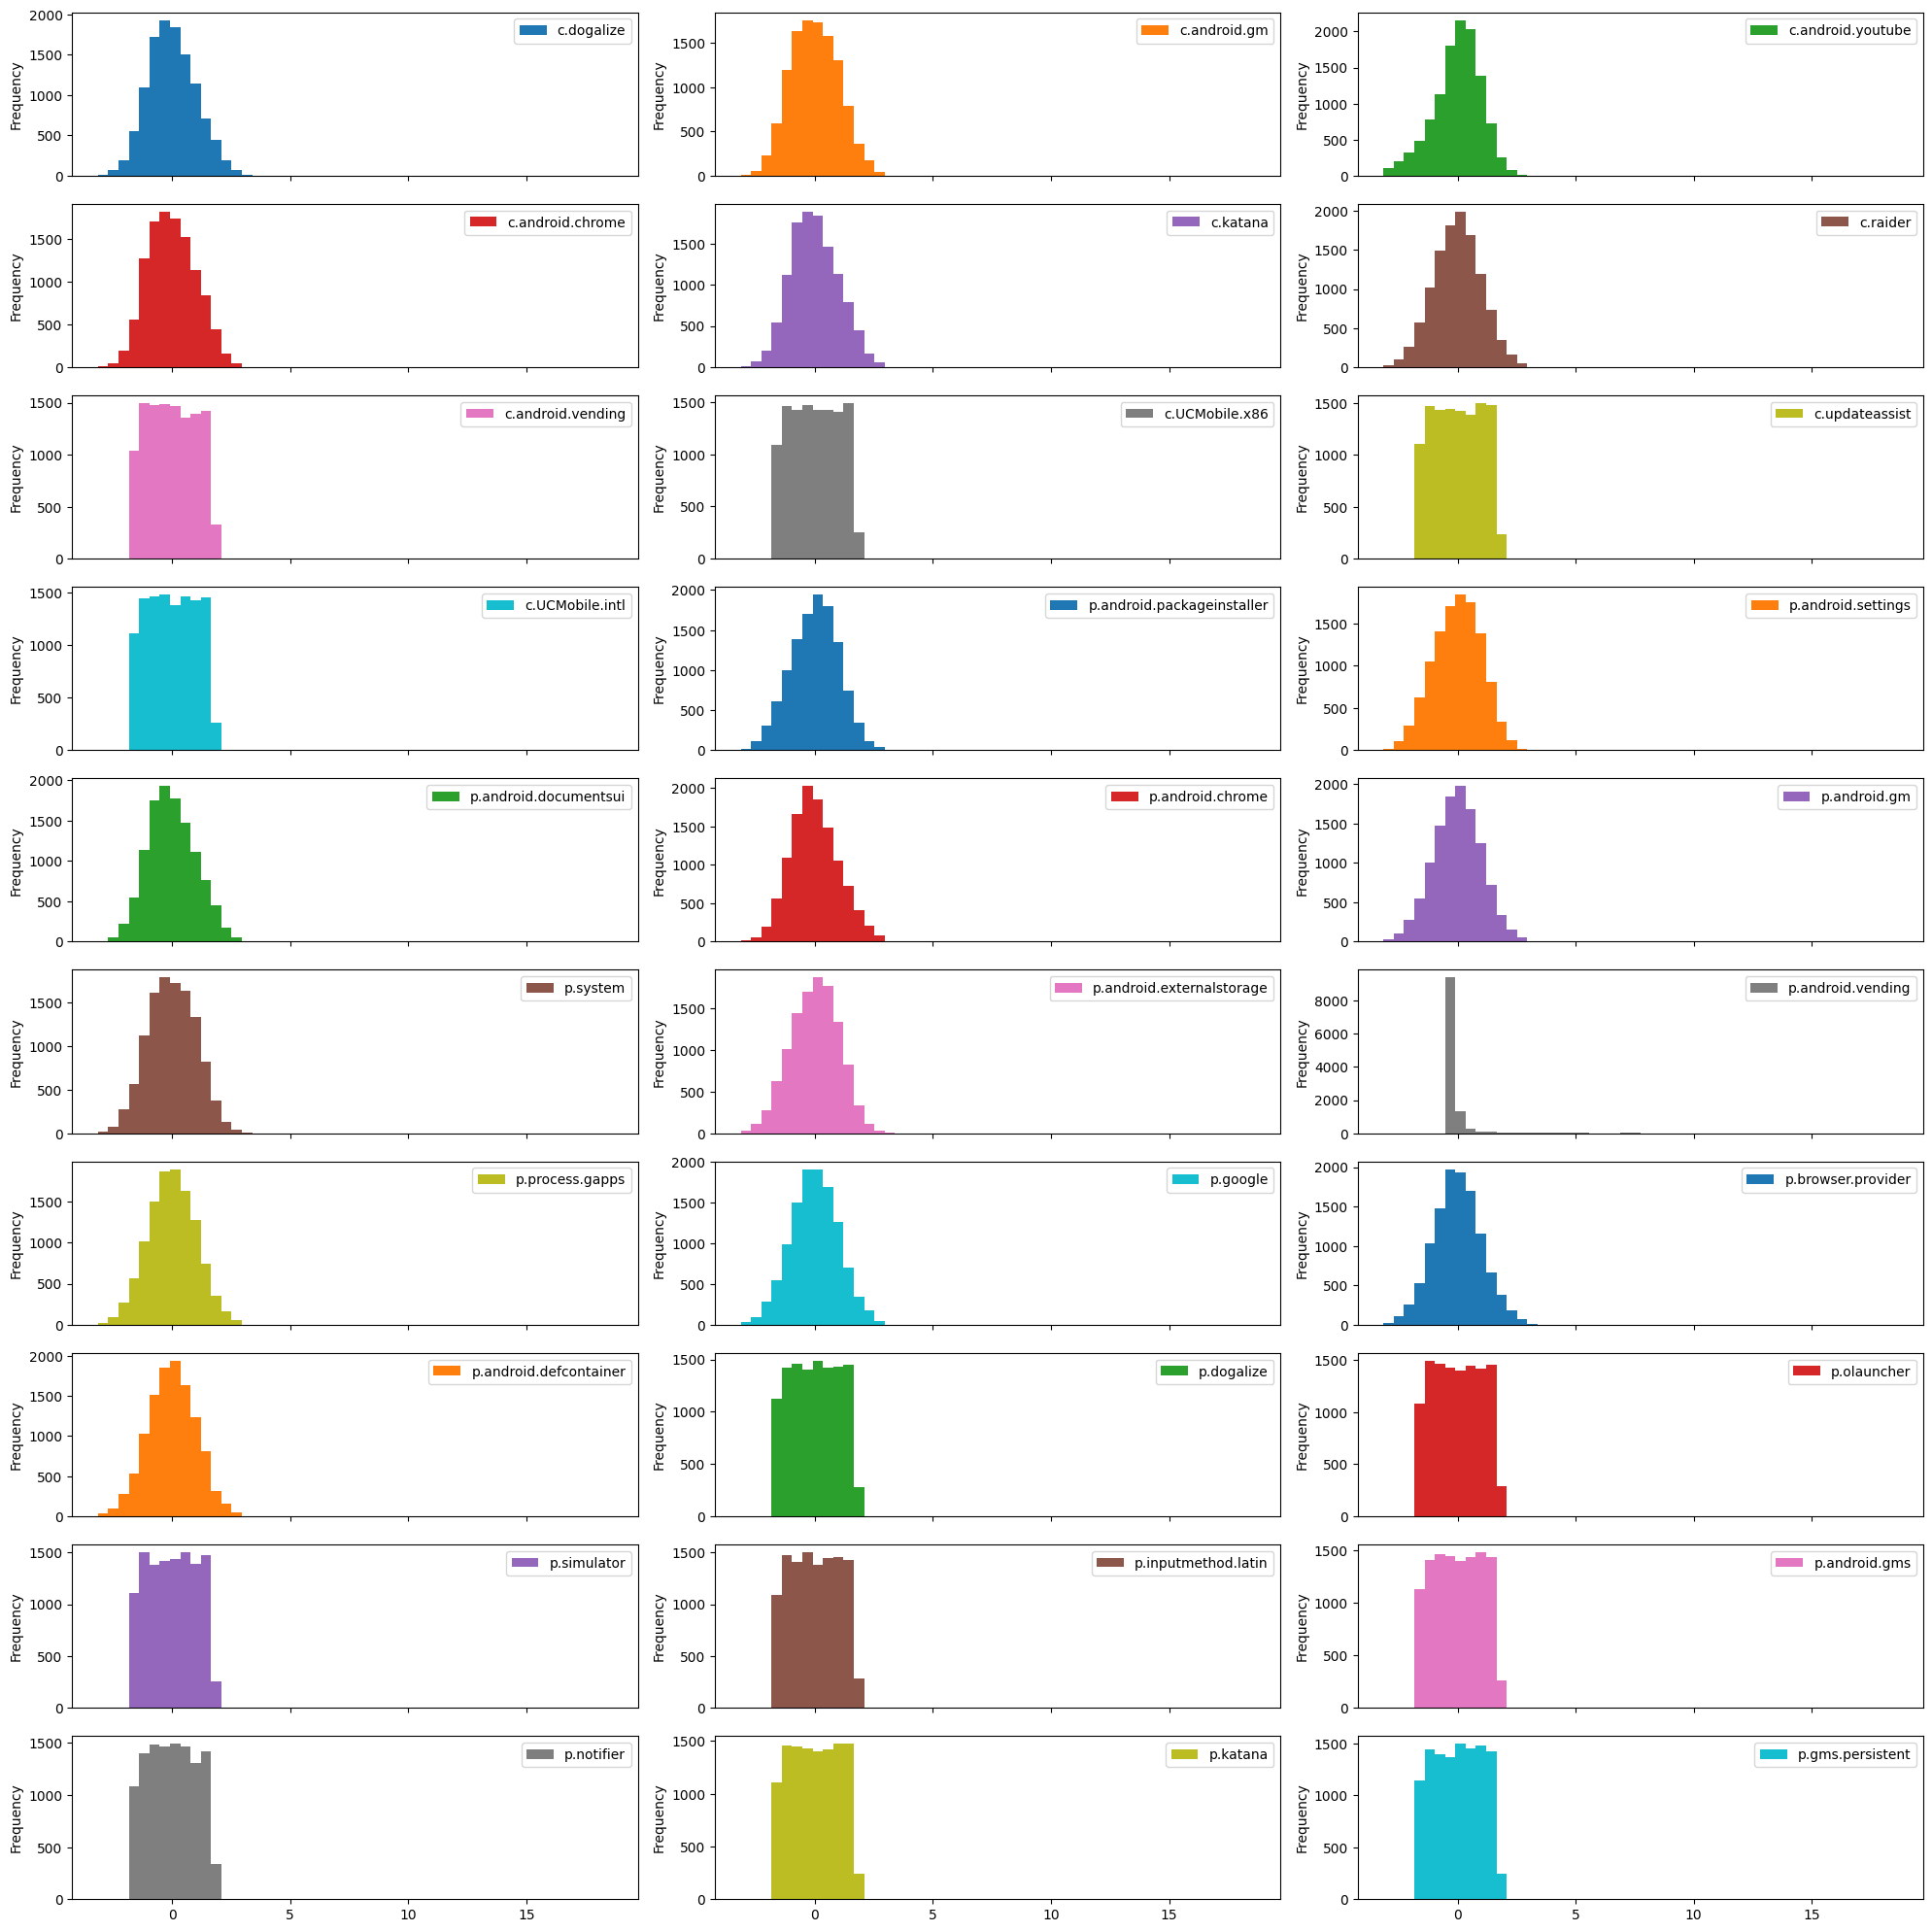

In [20]:
scaler = StandardScaler()
normalized_data = X.copy()
normalized_data[all_columns] = scaler.fit_transform(normalized_data[all_columns])

normalized_data.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

Showing plot without **"p.android.vending"** as it has too big range (can't see other graph that well)


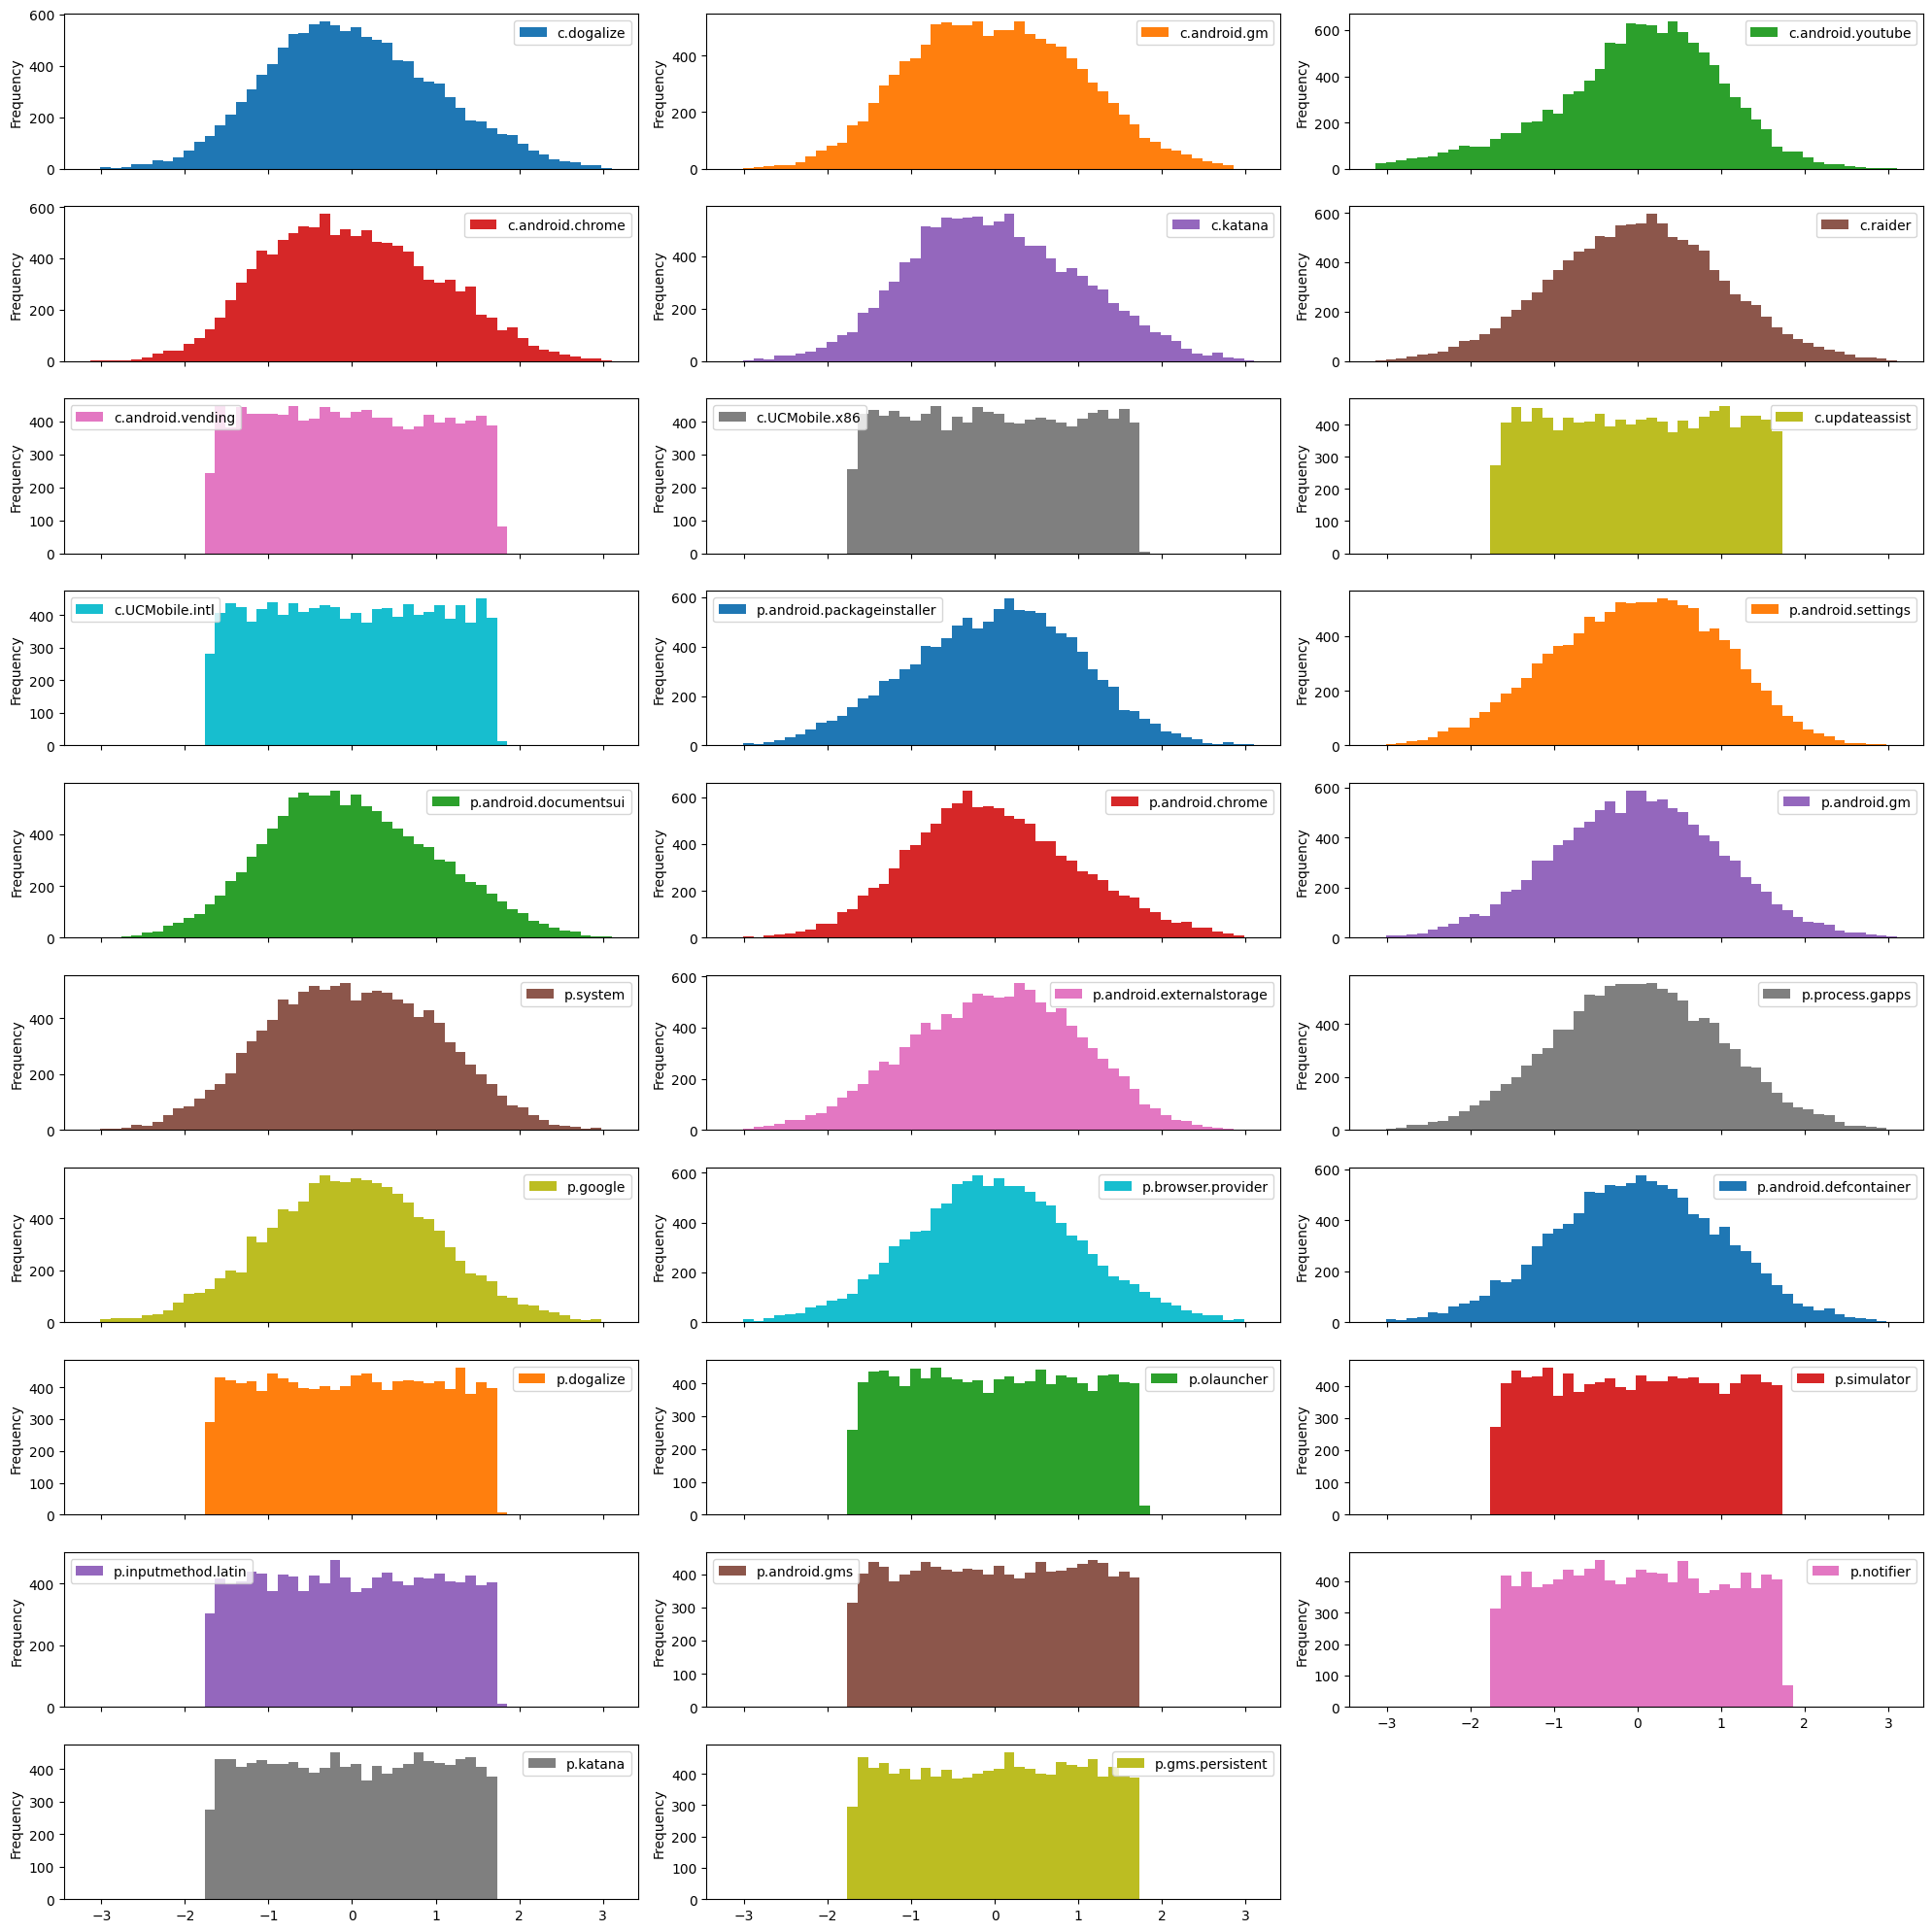

In [21]:
normalized_data.drop(columns=["p.android.vending"]).plot(
    kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3)
)
plt.tight_layout()
plt.show()

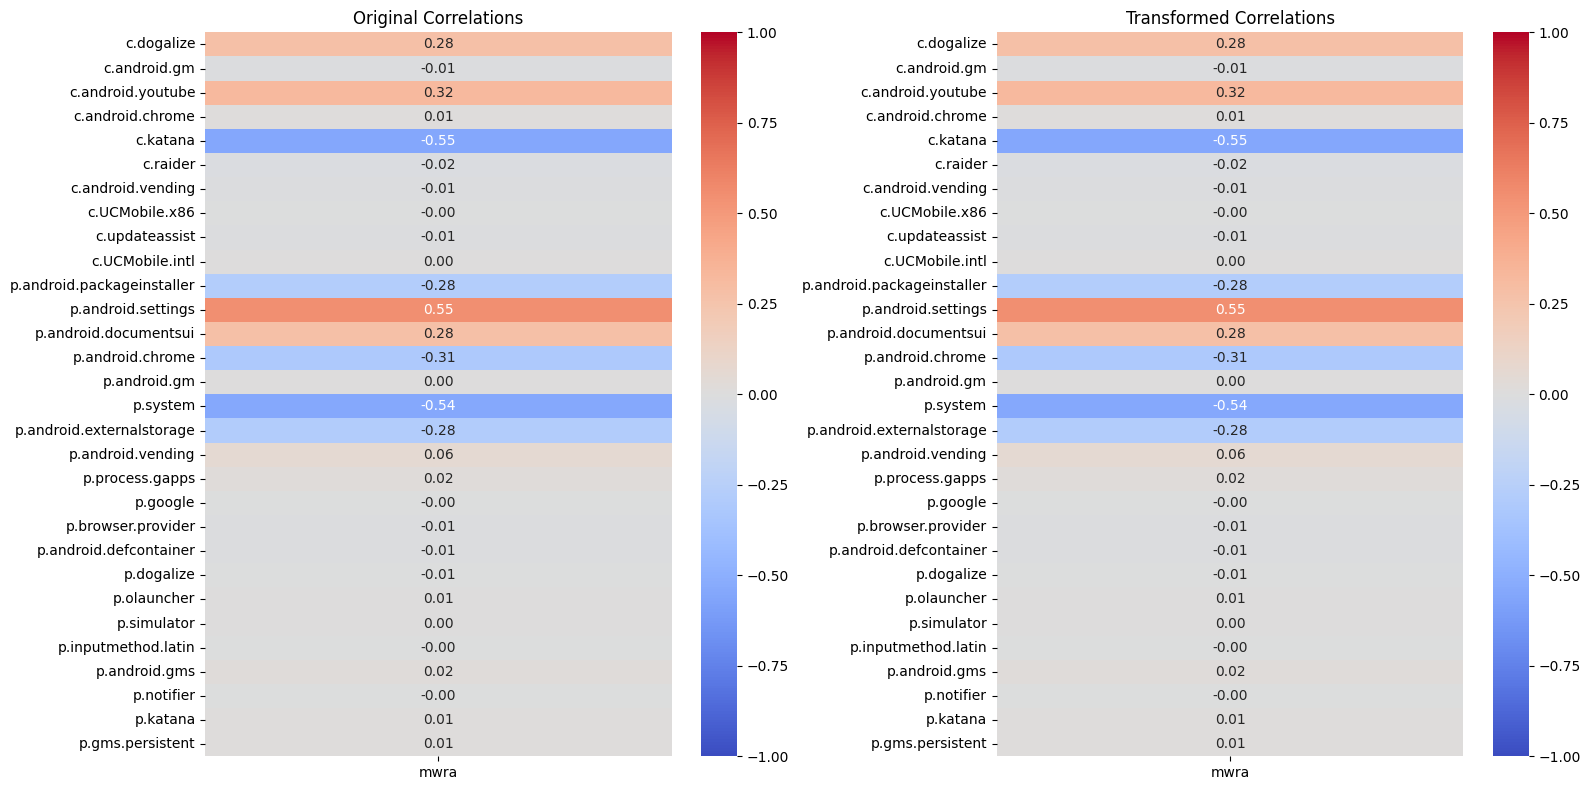

In [22]:
feature_columns = normalized_data.columns.tolist()

# Original correlations
combined_df_orig = pd.concat([X, train_data["mwra"]], axis=1).dropna()
corr_orig = combined_df_orig.corr(method="pearson")
filtered_corr_orig = corr_orig.loc[feature_columns, ["mwra"]]

# Transformed correlations
combined_df_trans = pd.concat([normalized_data, train_data["mwra"]], axis=1).dropna()
corr_trans = combined_df_trans.corr(method="pearson")
filtered_corr_trans = corr_trans.loc[feature_columns, ["mwra"]]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot original correlations
sns.heatmap(
    filtered_corr_orig,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax1,
)
ax1.set_title("Original Correlations")

# Plot transformed correlations
sns.heatmap(
    filtered_corr_trans,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax2,
)
ax2.set_title("Transformed Correlations")

plt.tight_layout()
plt.show()

### Using PowerTransformer


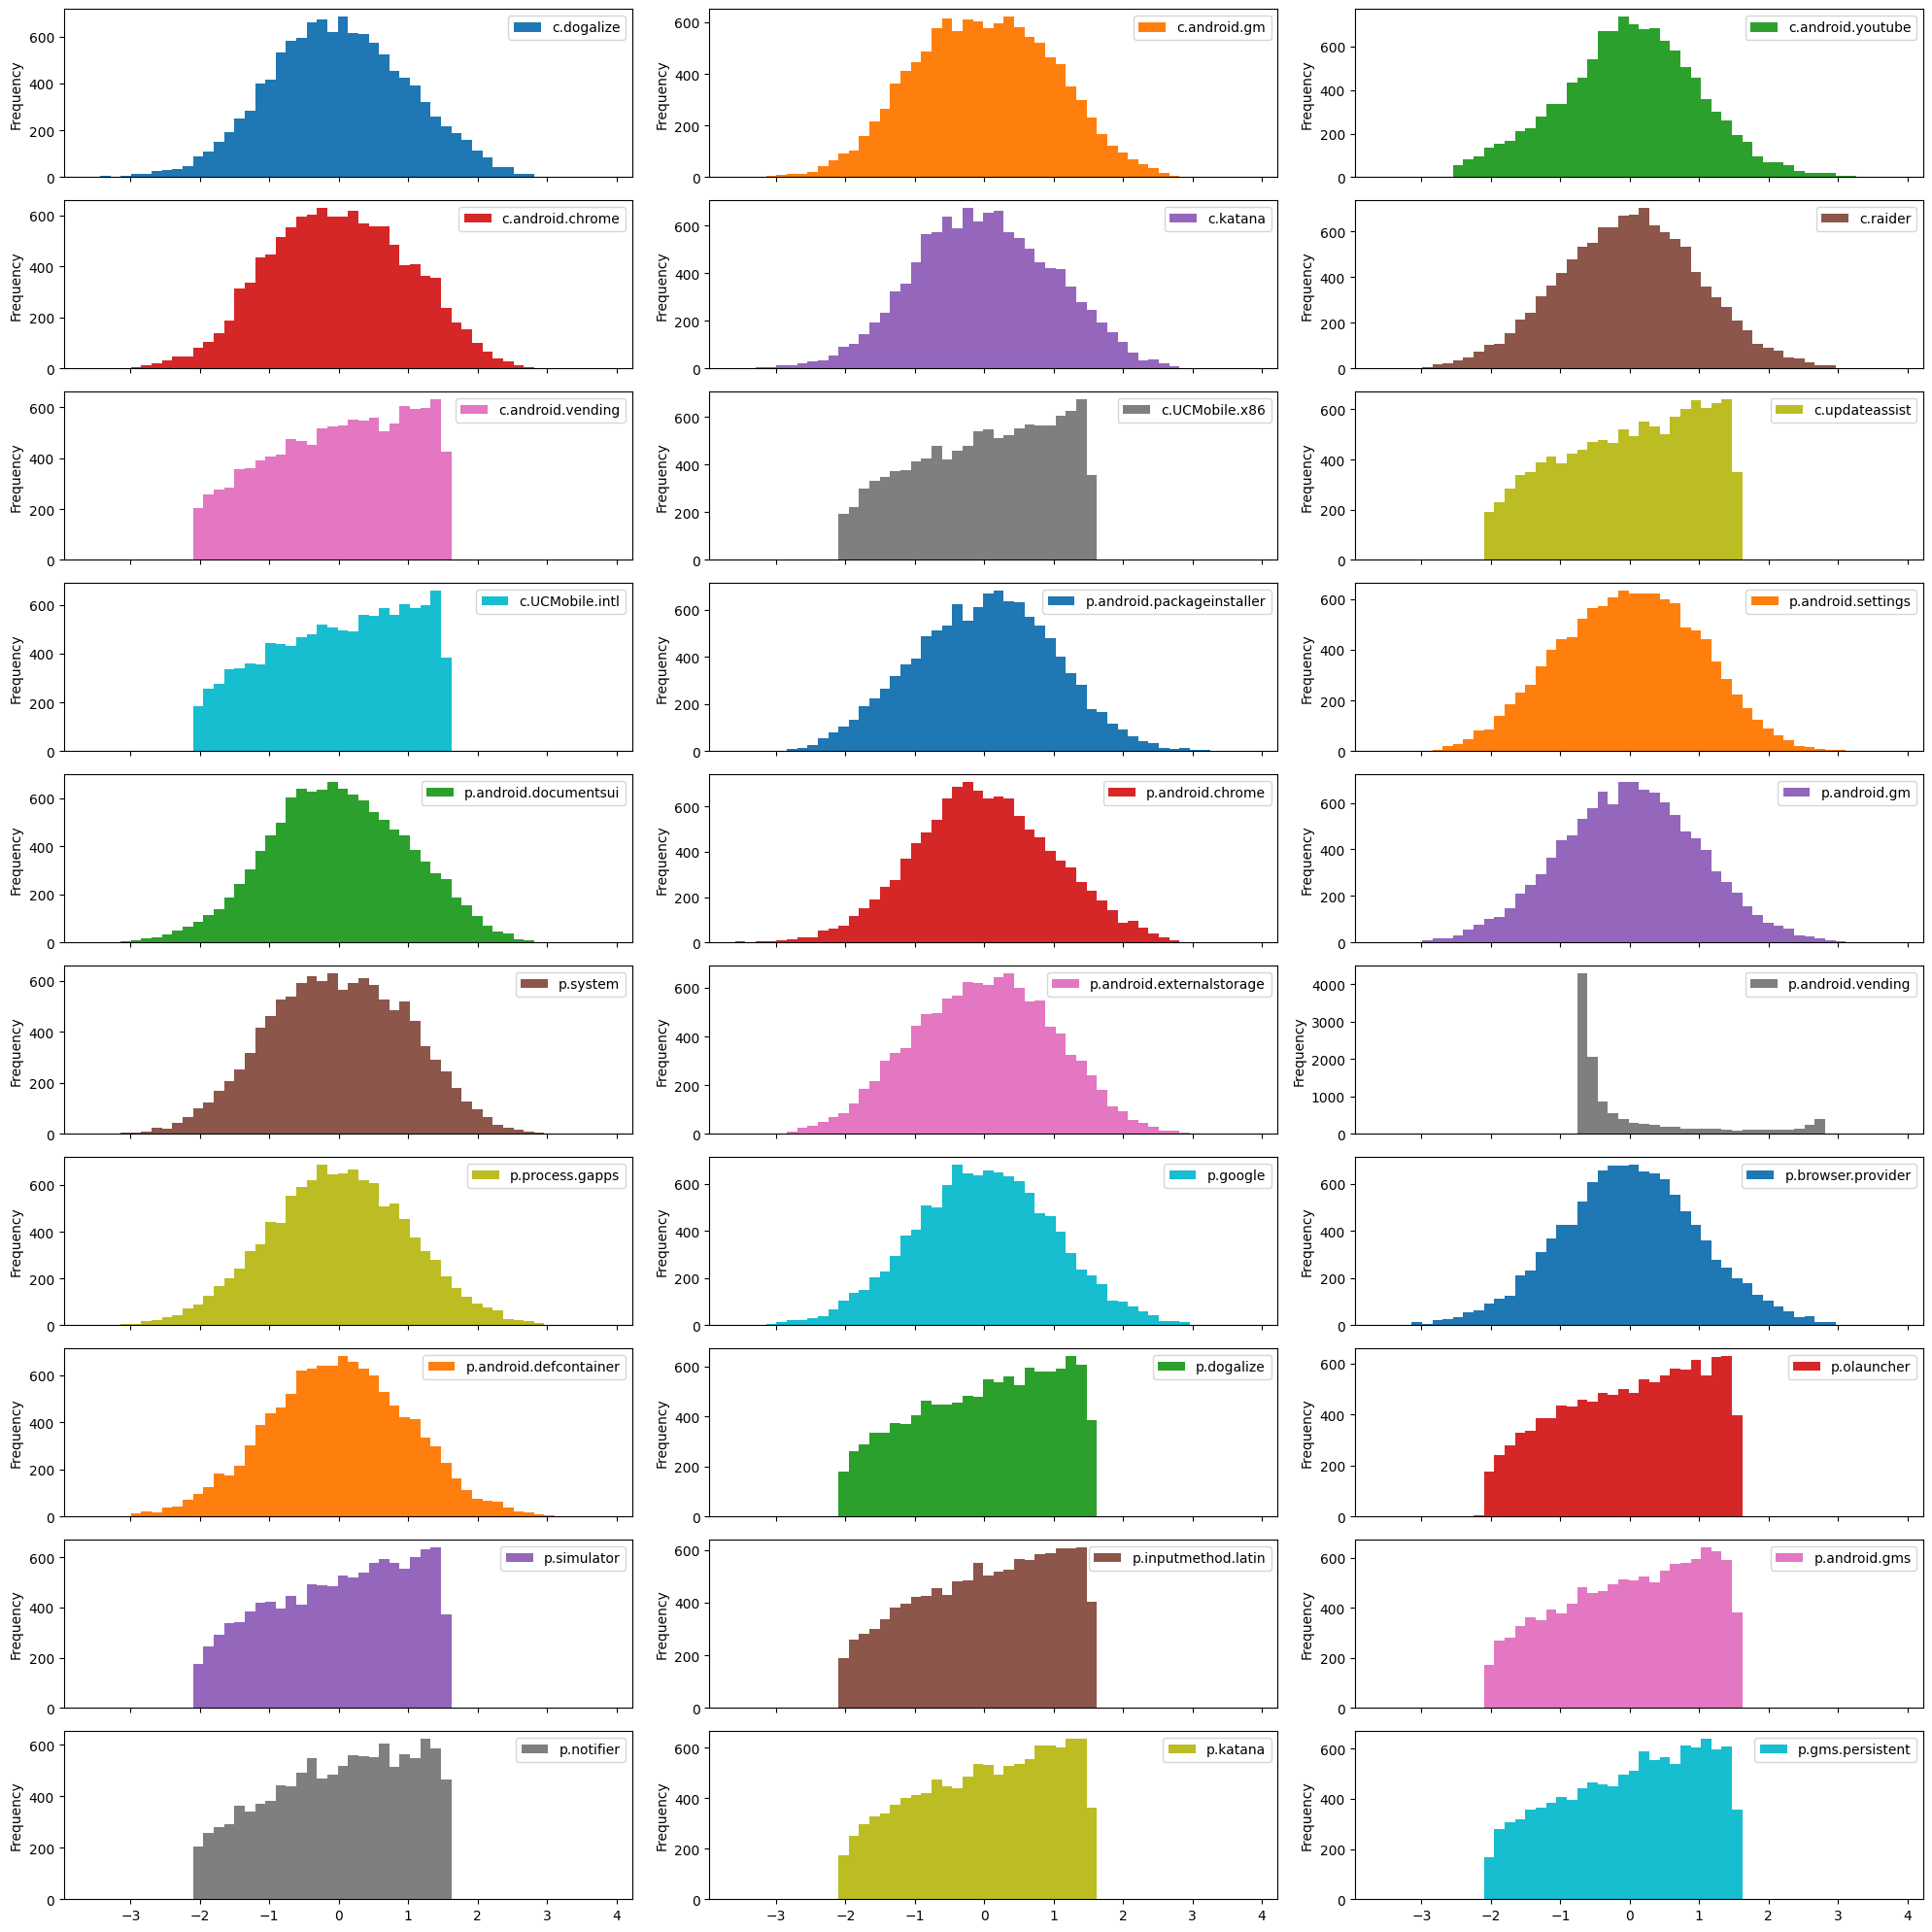

In [23]:
power_transformer = PowerTransformer(method="yeo-johnson")
normalized_data = X.copy()
normalized_data[all_columns] = power_transformer.fit_transform(normalized_data[all_columns])

normalized_data.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

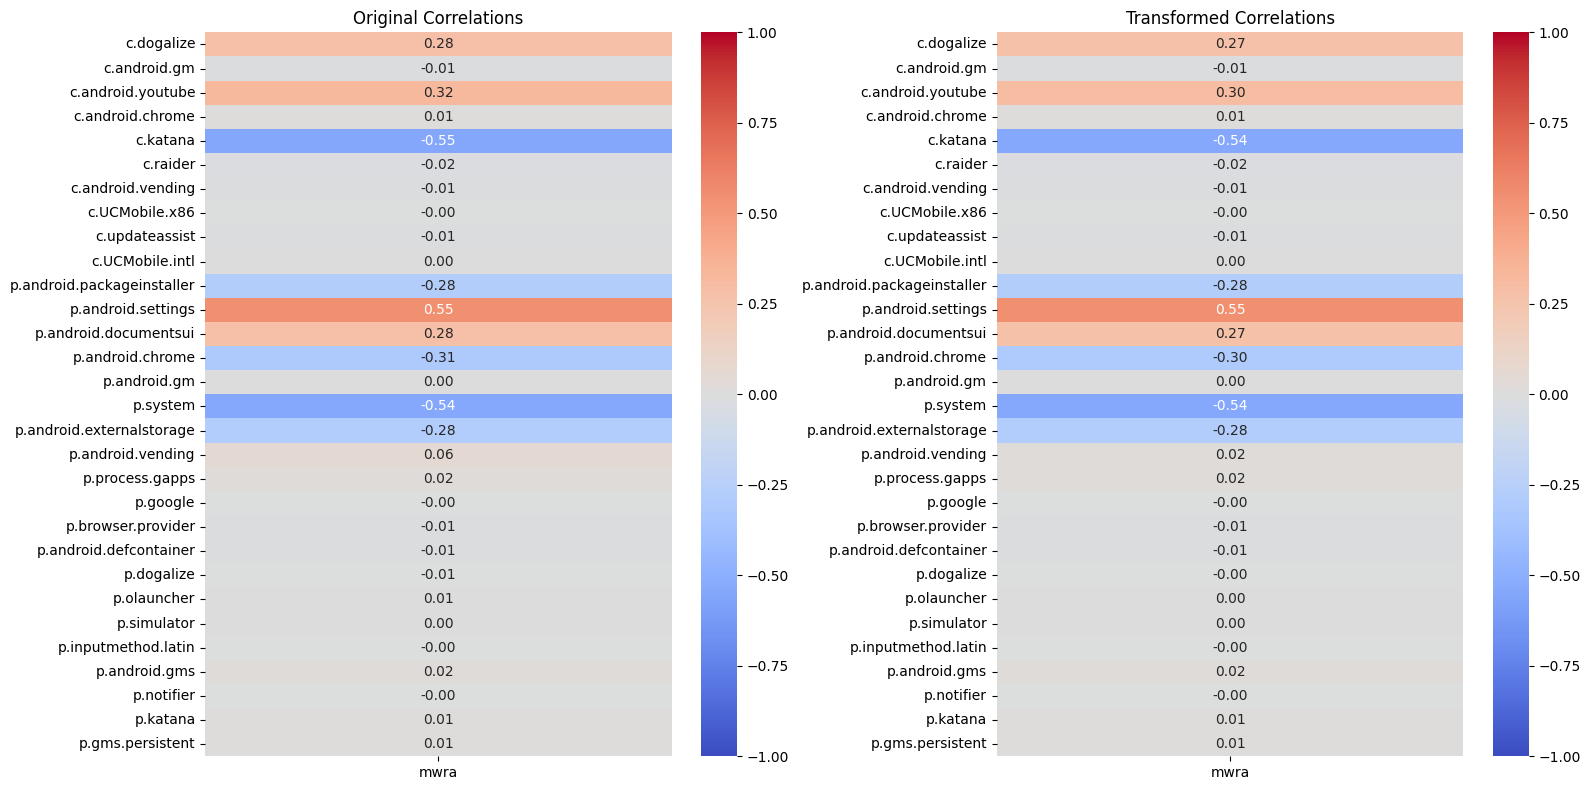

In [24]:
feature_columns = normalized_data.columns.tolist()

# Original correlations
combined_df_orig = pd.concat([X, train_data["mwra"]], axis=1).dropna()
corr_orig = combined_df_orig.corr(method="pearson")
filtered_corr_orig = corr_orig.loc[feature_columns, ["mwra"]]

# Transformed correlations
combined_df_trans = pd.concat([normalized_data, train_data["mwra"]], axis=1).dropna()
corr_trans = combined_df_trans.corr(method="pearson")
filtered_corr_trans = corr_trans.loc[feature_columns, ["mwra"]]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot original correlations
sns.heatmap(
    filtered_corr_orig,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax1,
)
ax1.set_title("Original Correlations")

# Plot transformed correlations
sns.heatmap(
    filtered_corr_trans,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax2,
)
ax2.set_title("Transformed Correlations")

plt.tight_layout()
plt.show()

### Using QuantileTransformer


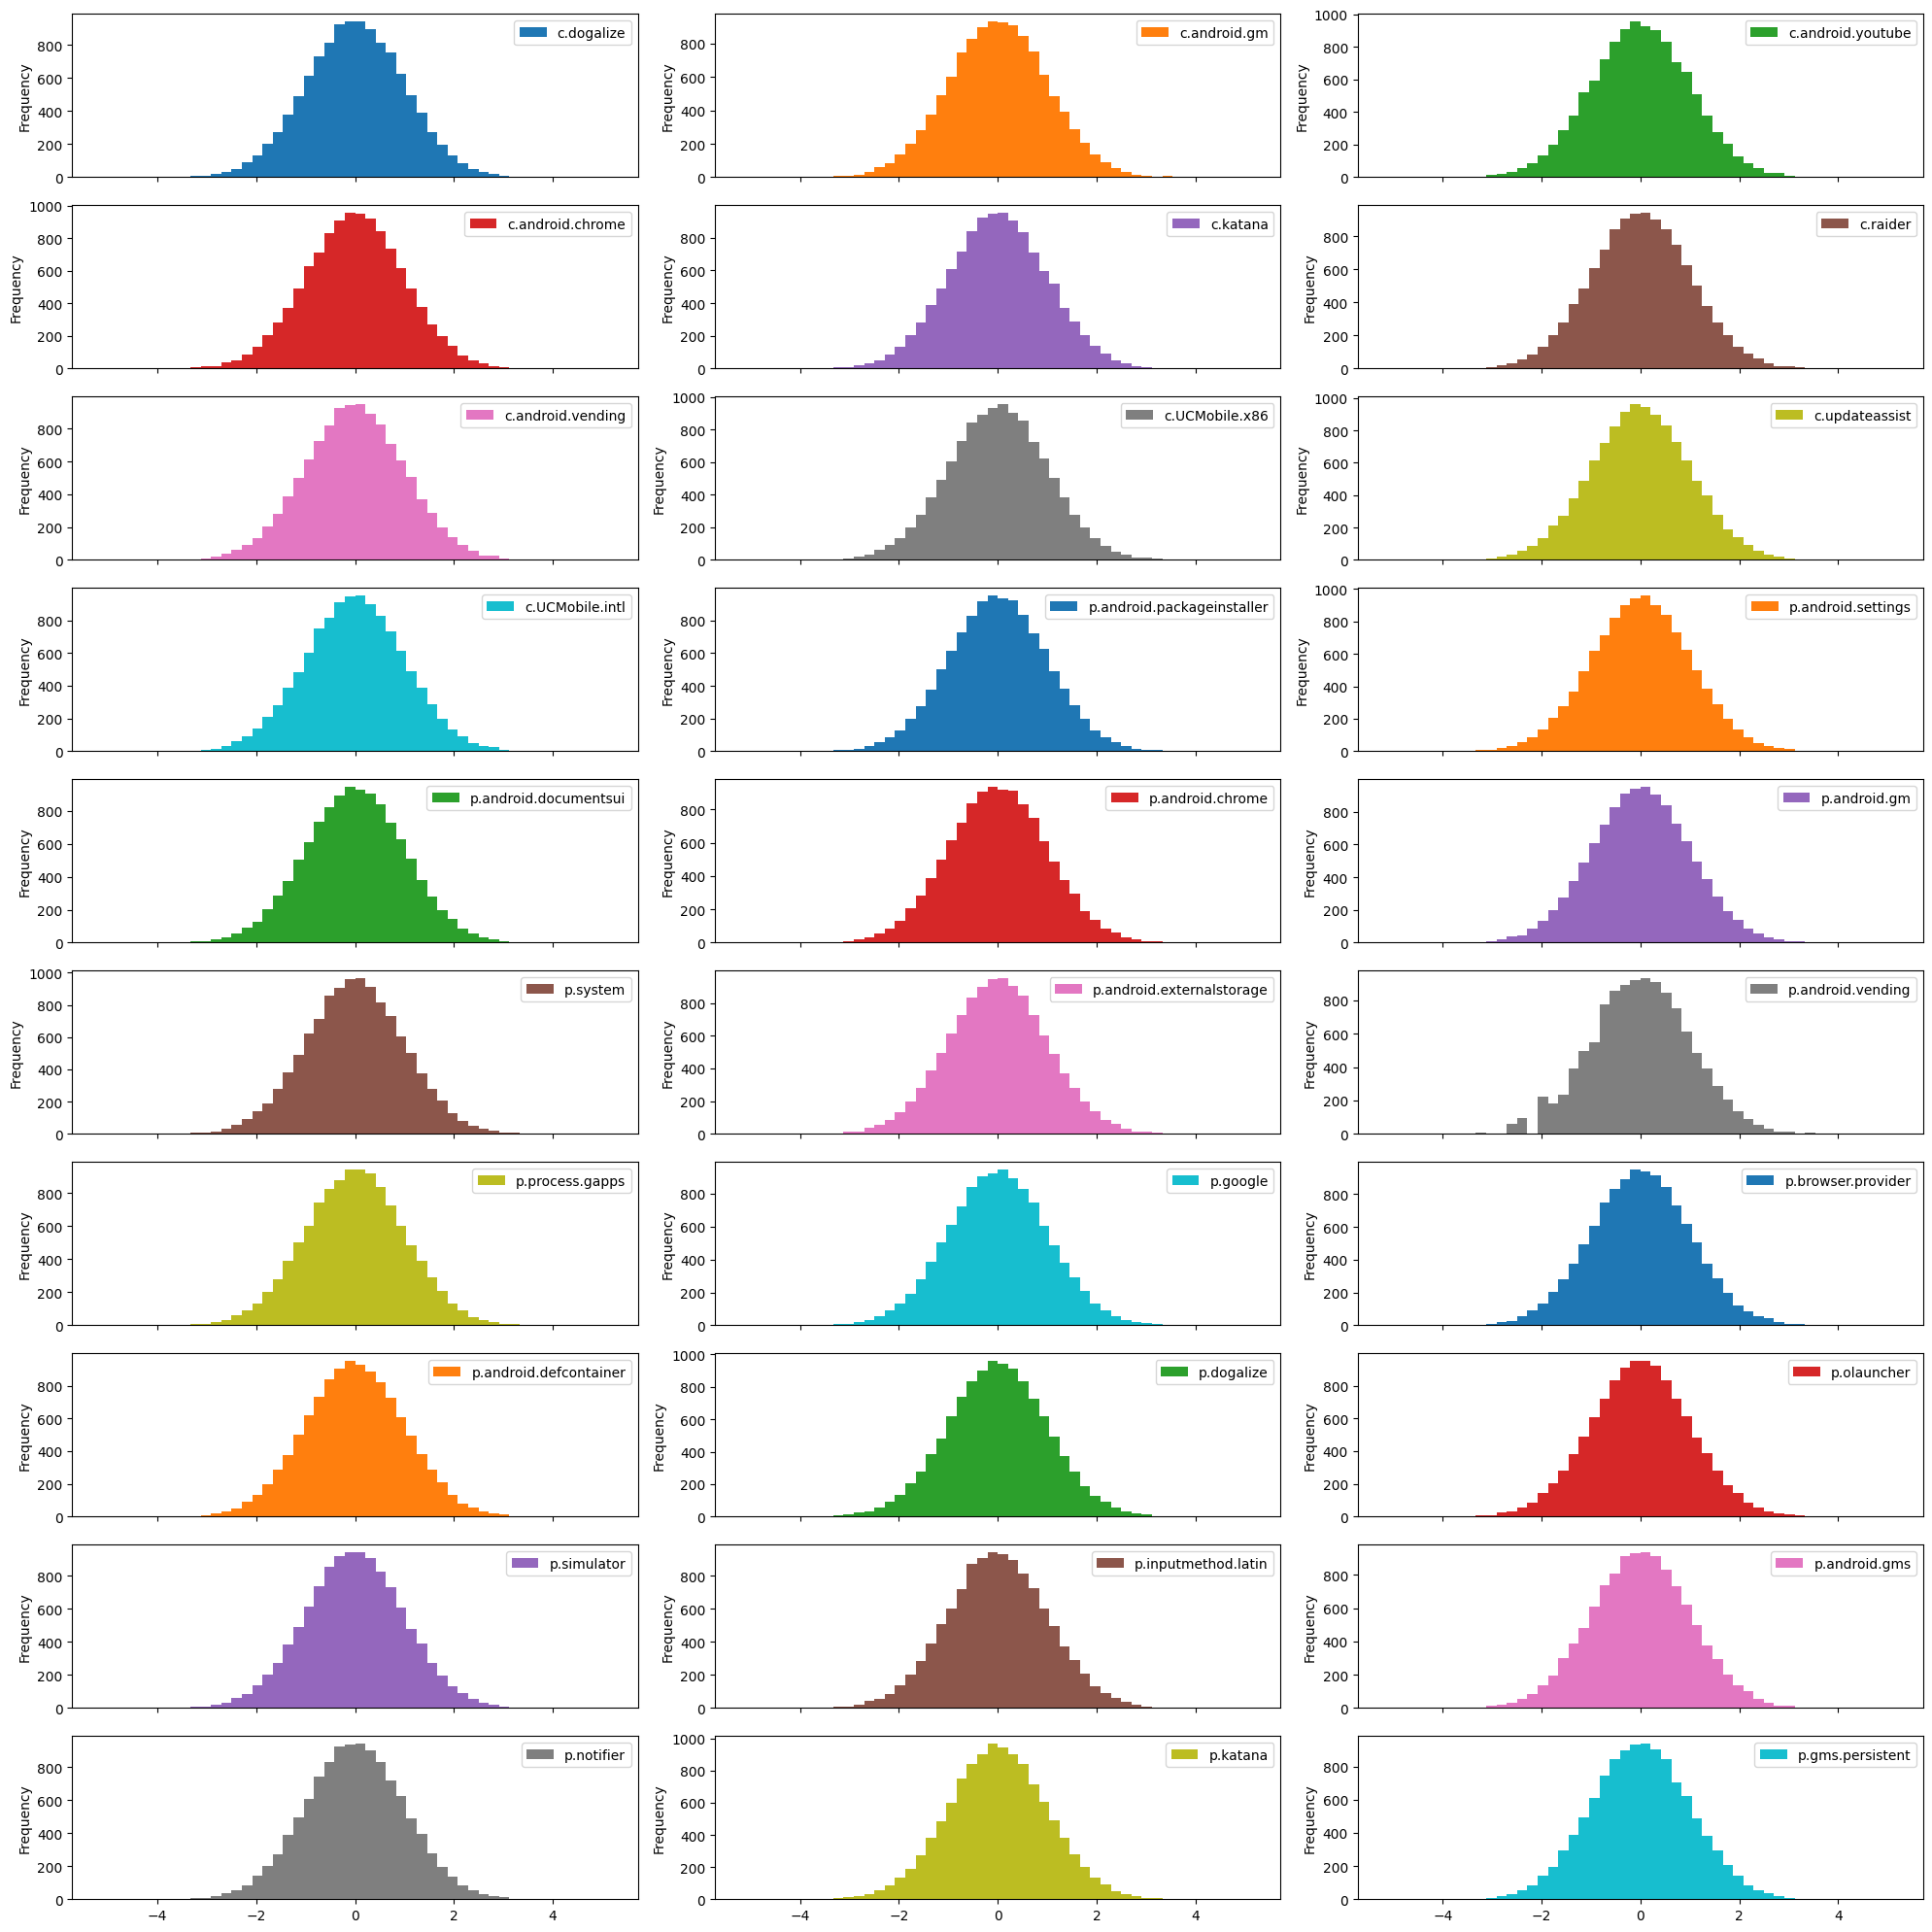

In [25]:
quantile_transformer = QuantileTransformer(output_distribution="normal", random_state=42)

normalized_data = X.copy()
normalized_data[all_columns] = quantile_transformer.fit_transform(normalized_data[all_columns])

normalized_data.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

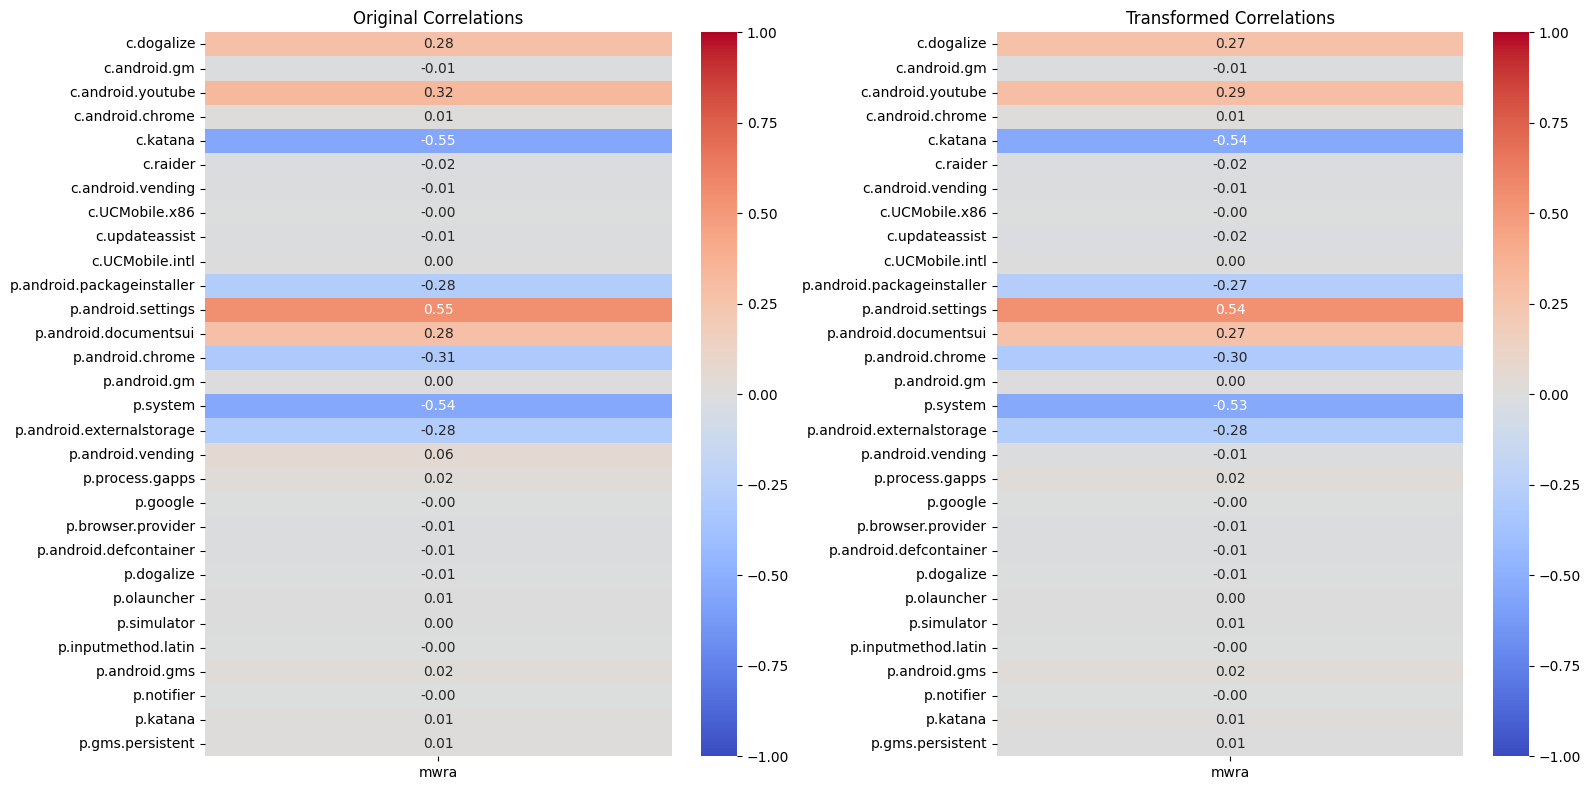

In [26]:
feature_columns = normalized_data.columns.tolist()

# Original correlations
combined_df_orig = pd.concat([X, train_data["mwra"]], axis=1).dropna()
corr_orig = combined_df_orig.corr(method="pearson")
filtered_corr_orig = corr_orig.loc[feature_columns, ["mwra"]]

# Transformed correlations
combined_df_trans = pd.concat([normalized_data, train_data["mwra"]], axis=1).dropna()
corr_trans = combined_df_trans.corr(method="pearson")
filtered_corr_trans = corr_trans.loc[feature_columns, ["mwra"]]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot original correlations
sns.heatmap(
    filtered_corr_orig,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax1,
)
ax1.set_title("Original Correlations")

# Plot transformed correlations
sns.heatmap(
    filtered_corr_trans,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax2,
)
ax2.set_title("Transformed Correlations")

plt.tight_layout()
plt.show()

### Using MinMaxScaler then PowerTransformer


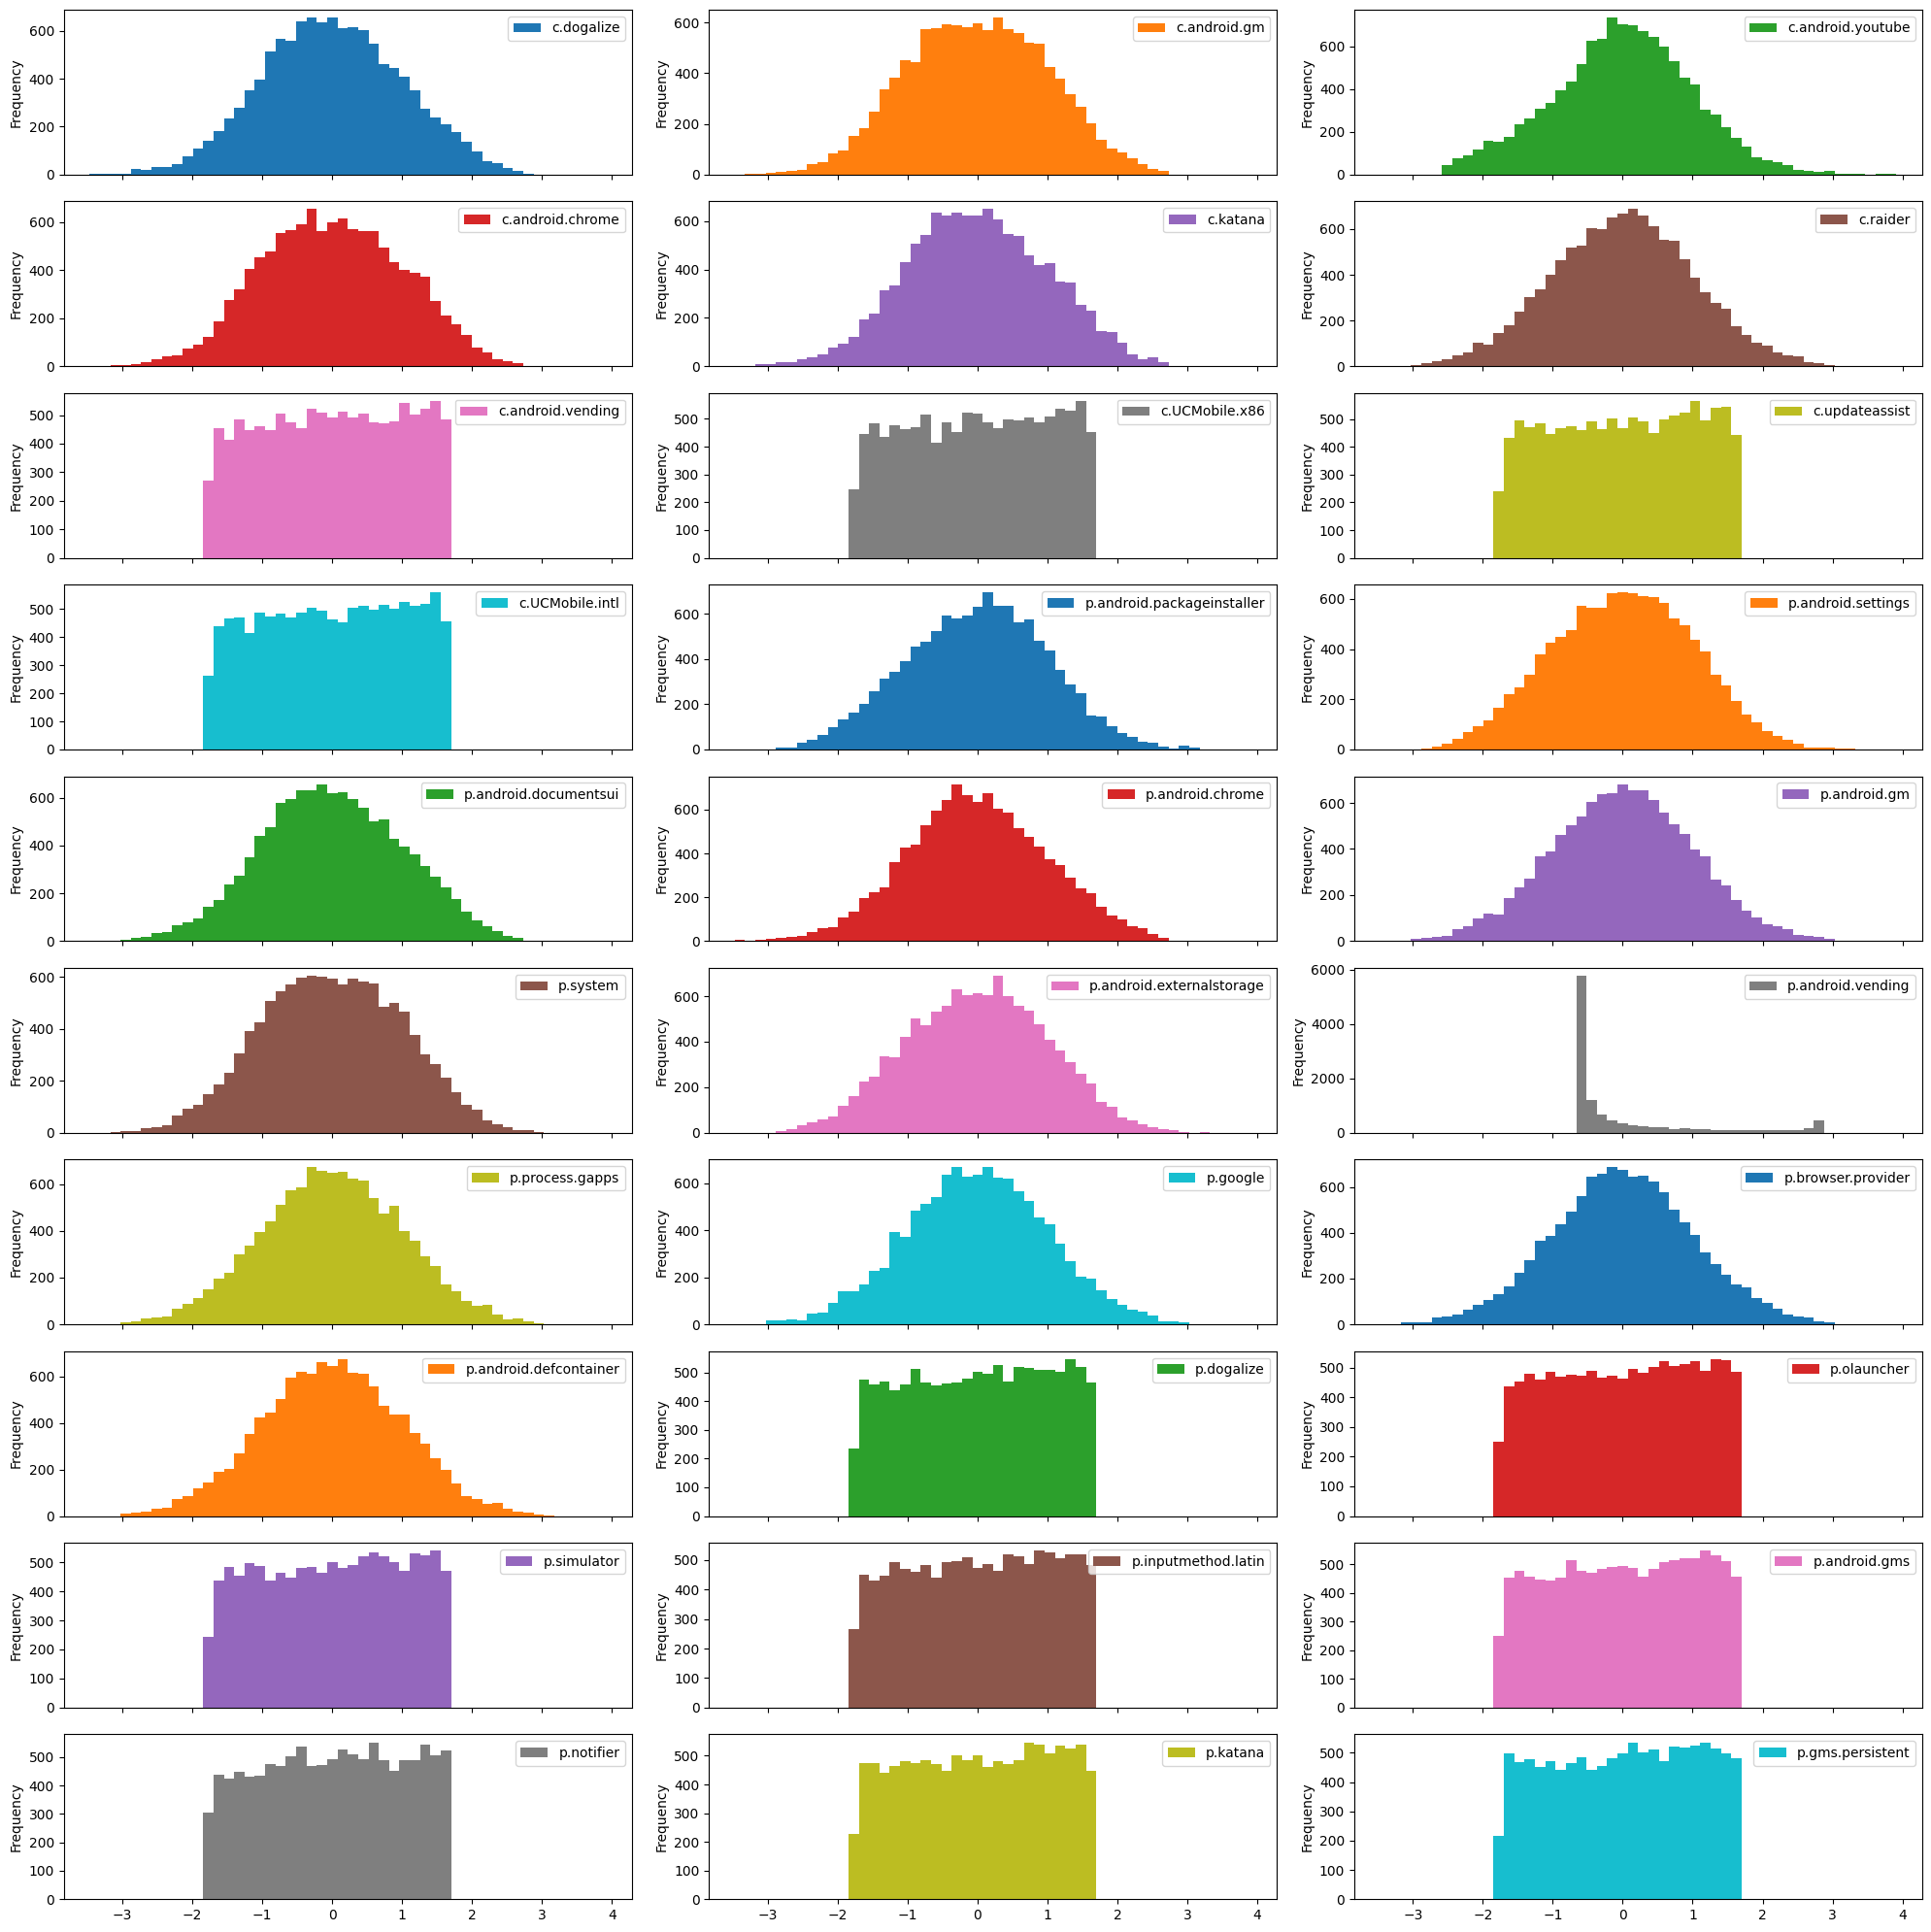

In [27]:
# Define scaler and transformer
scaler = MinMaxScaler()
power_transformer = PowerTransformer(method="yeo-johnson")

normalized_data = X.copy()

# Scale data using MinMaxScaler
normalized_data[all_columns] = scaler.fit_transform(normalized_data[all_columns])

# Transform data using PowerTransformer
normalized_data[all_columns] = power_transformer.fit_transform(normalized_data[all_columns])

# Plot histograms
normalized_data.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

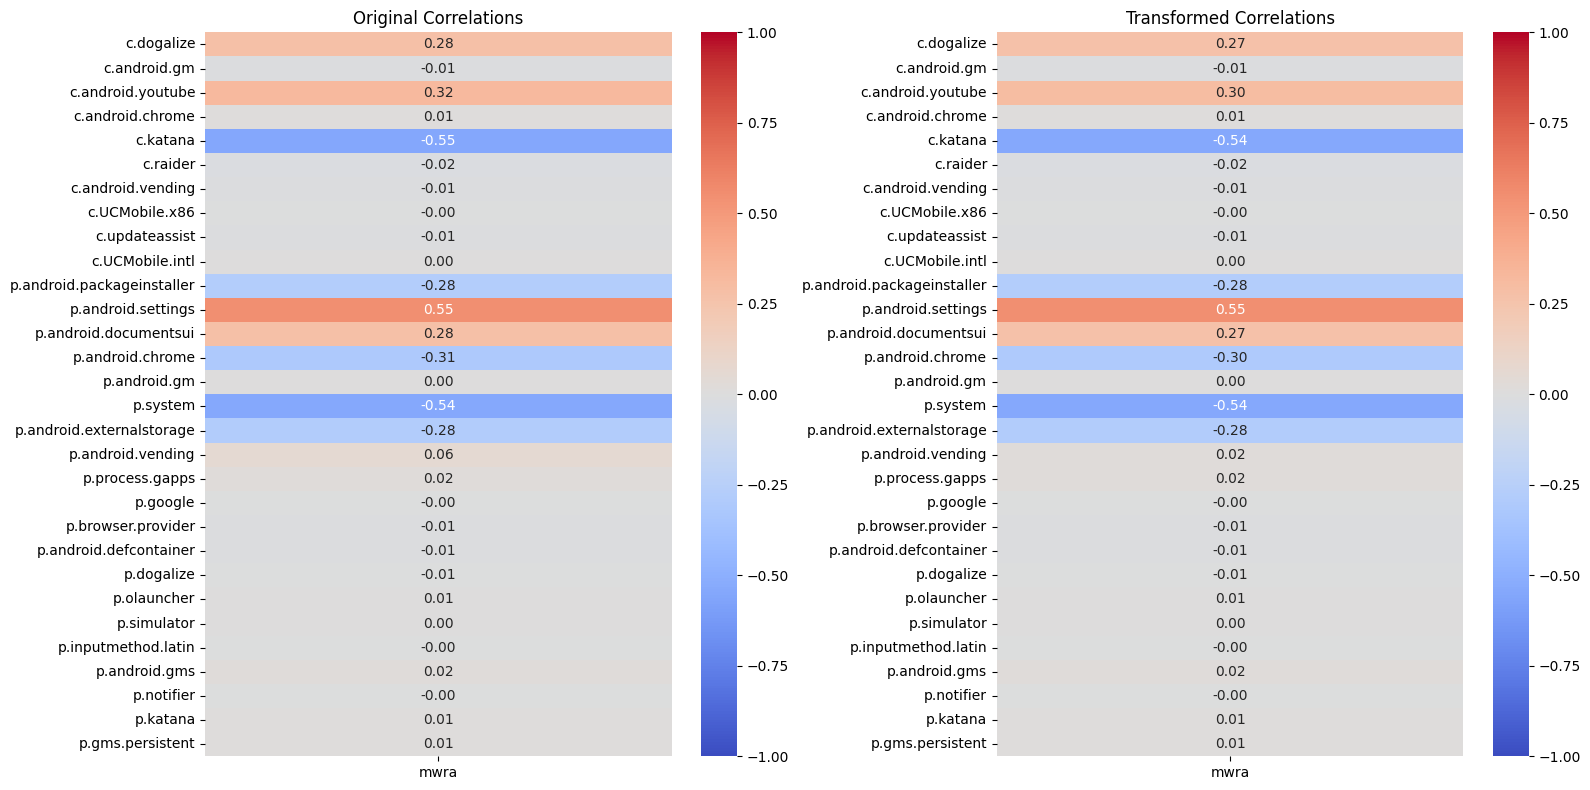

In [28]:
feature_columns = normalized_data.columns.tolist()

# Original correlations
combined_df_orig = pd.concat([X, train_data["mwra"]], axis=1).dropna()
corr_orig = combined_df_orig.corr(method="pearson")
filtered_corr_orig = corr_orig.loc[feature_columns, ["mwra"]]

# Transformed correlations
combined_df_trans = pd.concat([normalized_data, train_data["mwra"]], axis=1).dropna()
corr_trans = combined_df_trans.corr(method="pearson")
filtered_corr_trans = corr_trans.loc[feature_columns, ["mwra"]]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot original correlations
sns.heatmap(
    filtered_corr_orig,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax1,
)
ax1.set_title("Original Correlations")

# Plot transformed correlations
sns.heatmap(
    filtered_corr_trans,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax2,
)
ax2.set_title("Transformed Correlations")

plt.tight_layout()
plt.show()

### Using StandardScaler then PowerTransformer


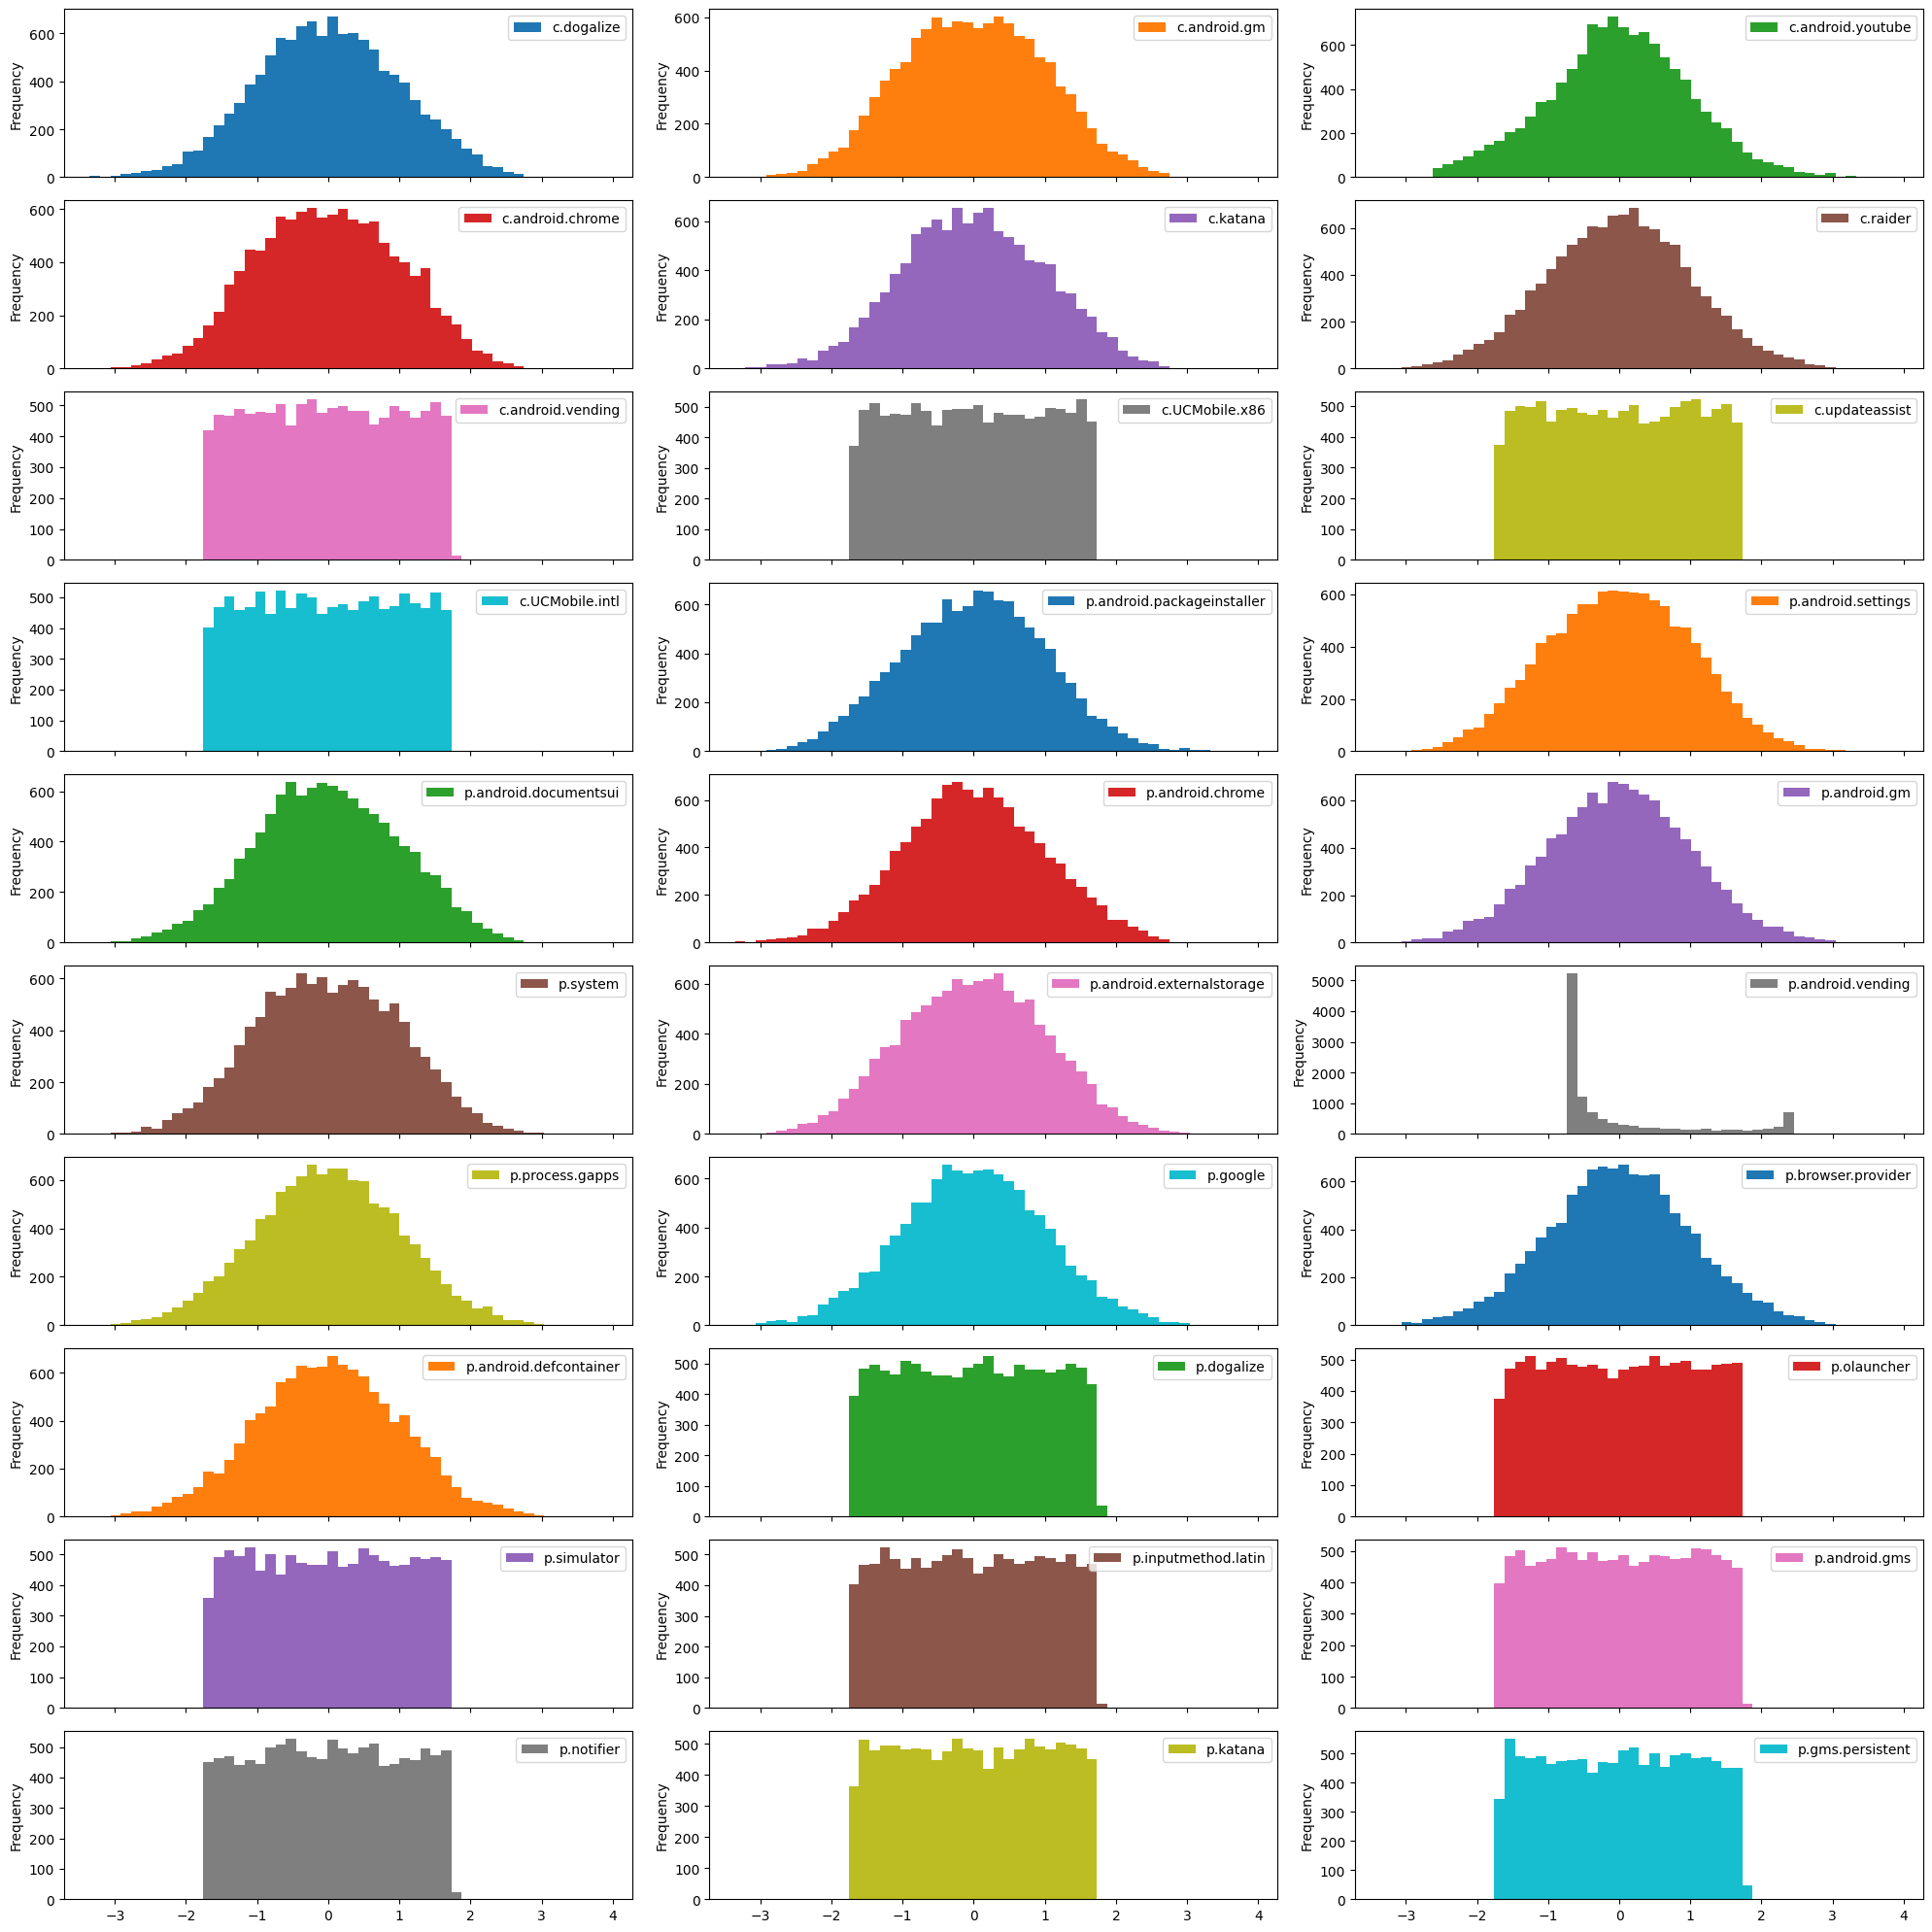

In [29]:
# Define scaler and transformer
scaler = StandardScaler()
power_transformer = PowerTransformer(method="yeo-johnson")

normalized_data = X.copy()

# Scale data using StandardScaler
normalized_data[all_columns] = scaler.fit_transform(normalized_data[all_columns])

# Transform data using PowerTransformer
normalized_data[all_columns] = power_transformer.fit_transform(normalized_data[all_columns])

# Plot histograms
normalized_data.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

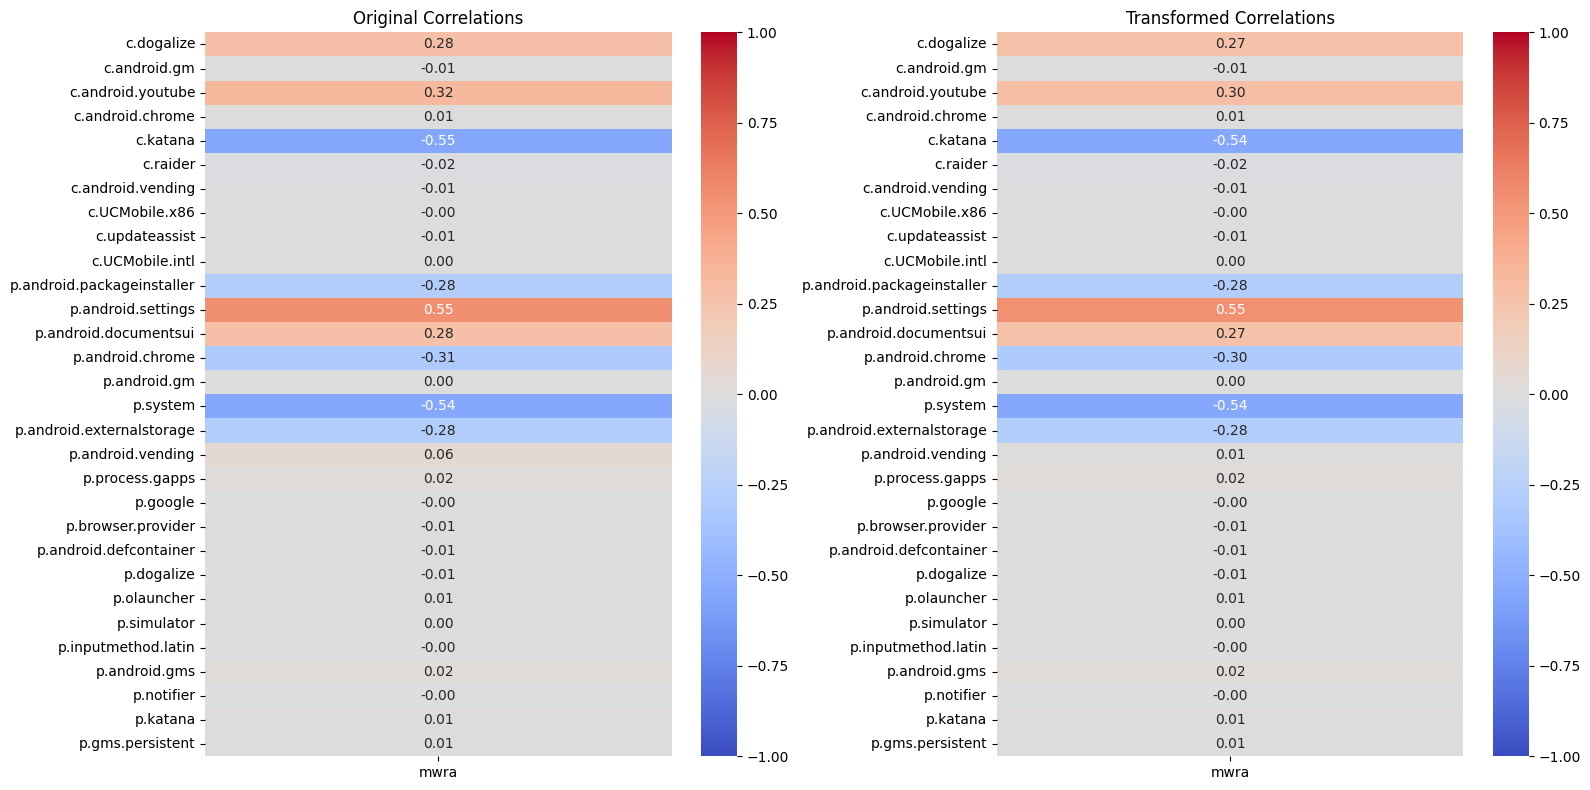

In [30]:
feature_columns = normalized_data.columns.tolist()

# Original correlations
combined_df_orig = pd.concat([X, train_data["mwra"]], axis=1).dropna()
corr_orig = combined_df_orig.corr(method="pearson")
filtered_corr_orig = corr_orig.loc[feature_columns, ["mwra"]]

# Transformed correlations
combined_df_trans = pd.concat([normalized_data, train_data["mwra"]], axis=1).dropna()
corr_trans = combined_df_trans.corr(method="pearson")
filtered_corr_trans = corr_trans.loc[feature_columns, ["mwra"]]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot original correlations
sns.heatmap(
    filtered_corr_orig,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax1,
)
ax1.set_title("Original Correlations")

# Plot transformed correlations
sns.heatmap(
    filtered_corr_trans,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax2,
)
ax2.set_title("Transformed Correlations")

plt.tight_layout()
plt.show()

### Using PowerTransformer then StandardScaler


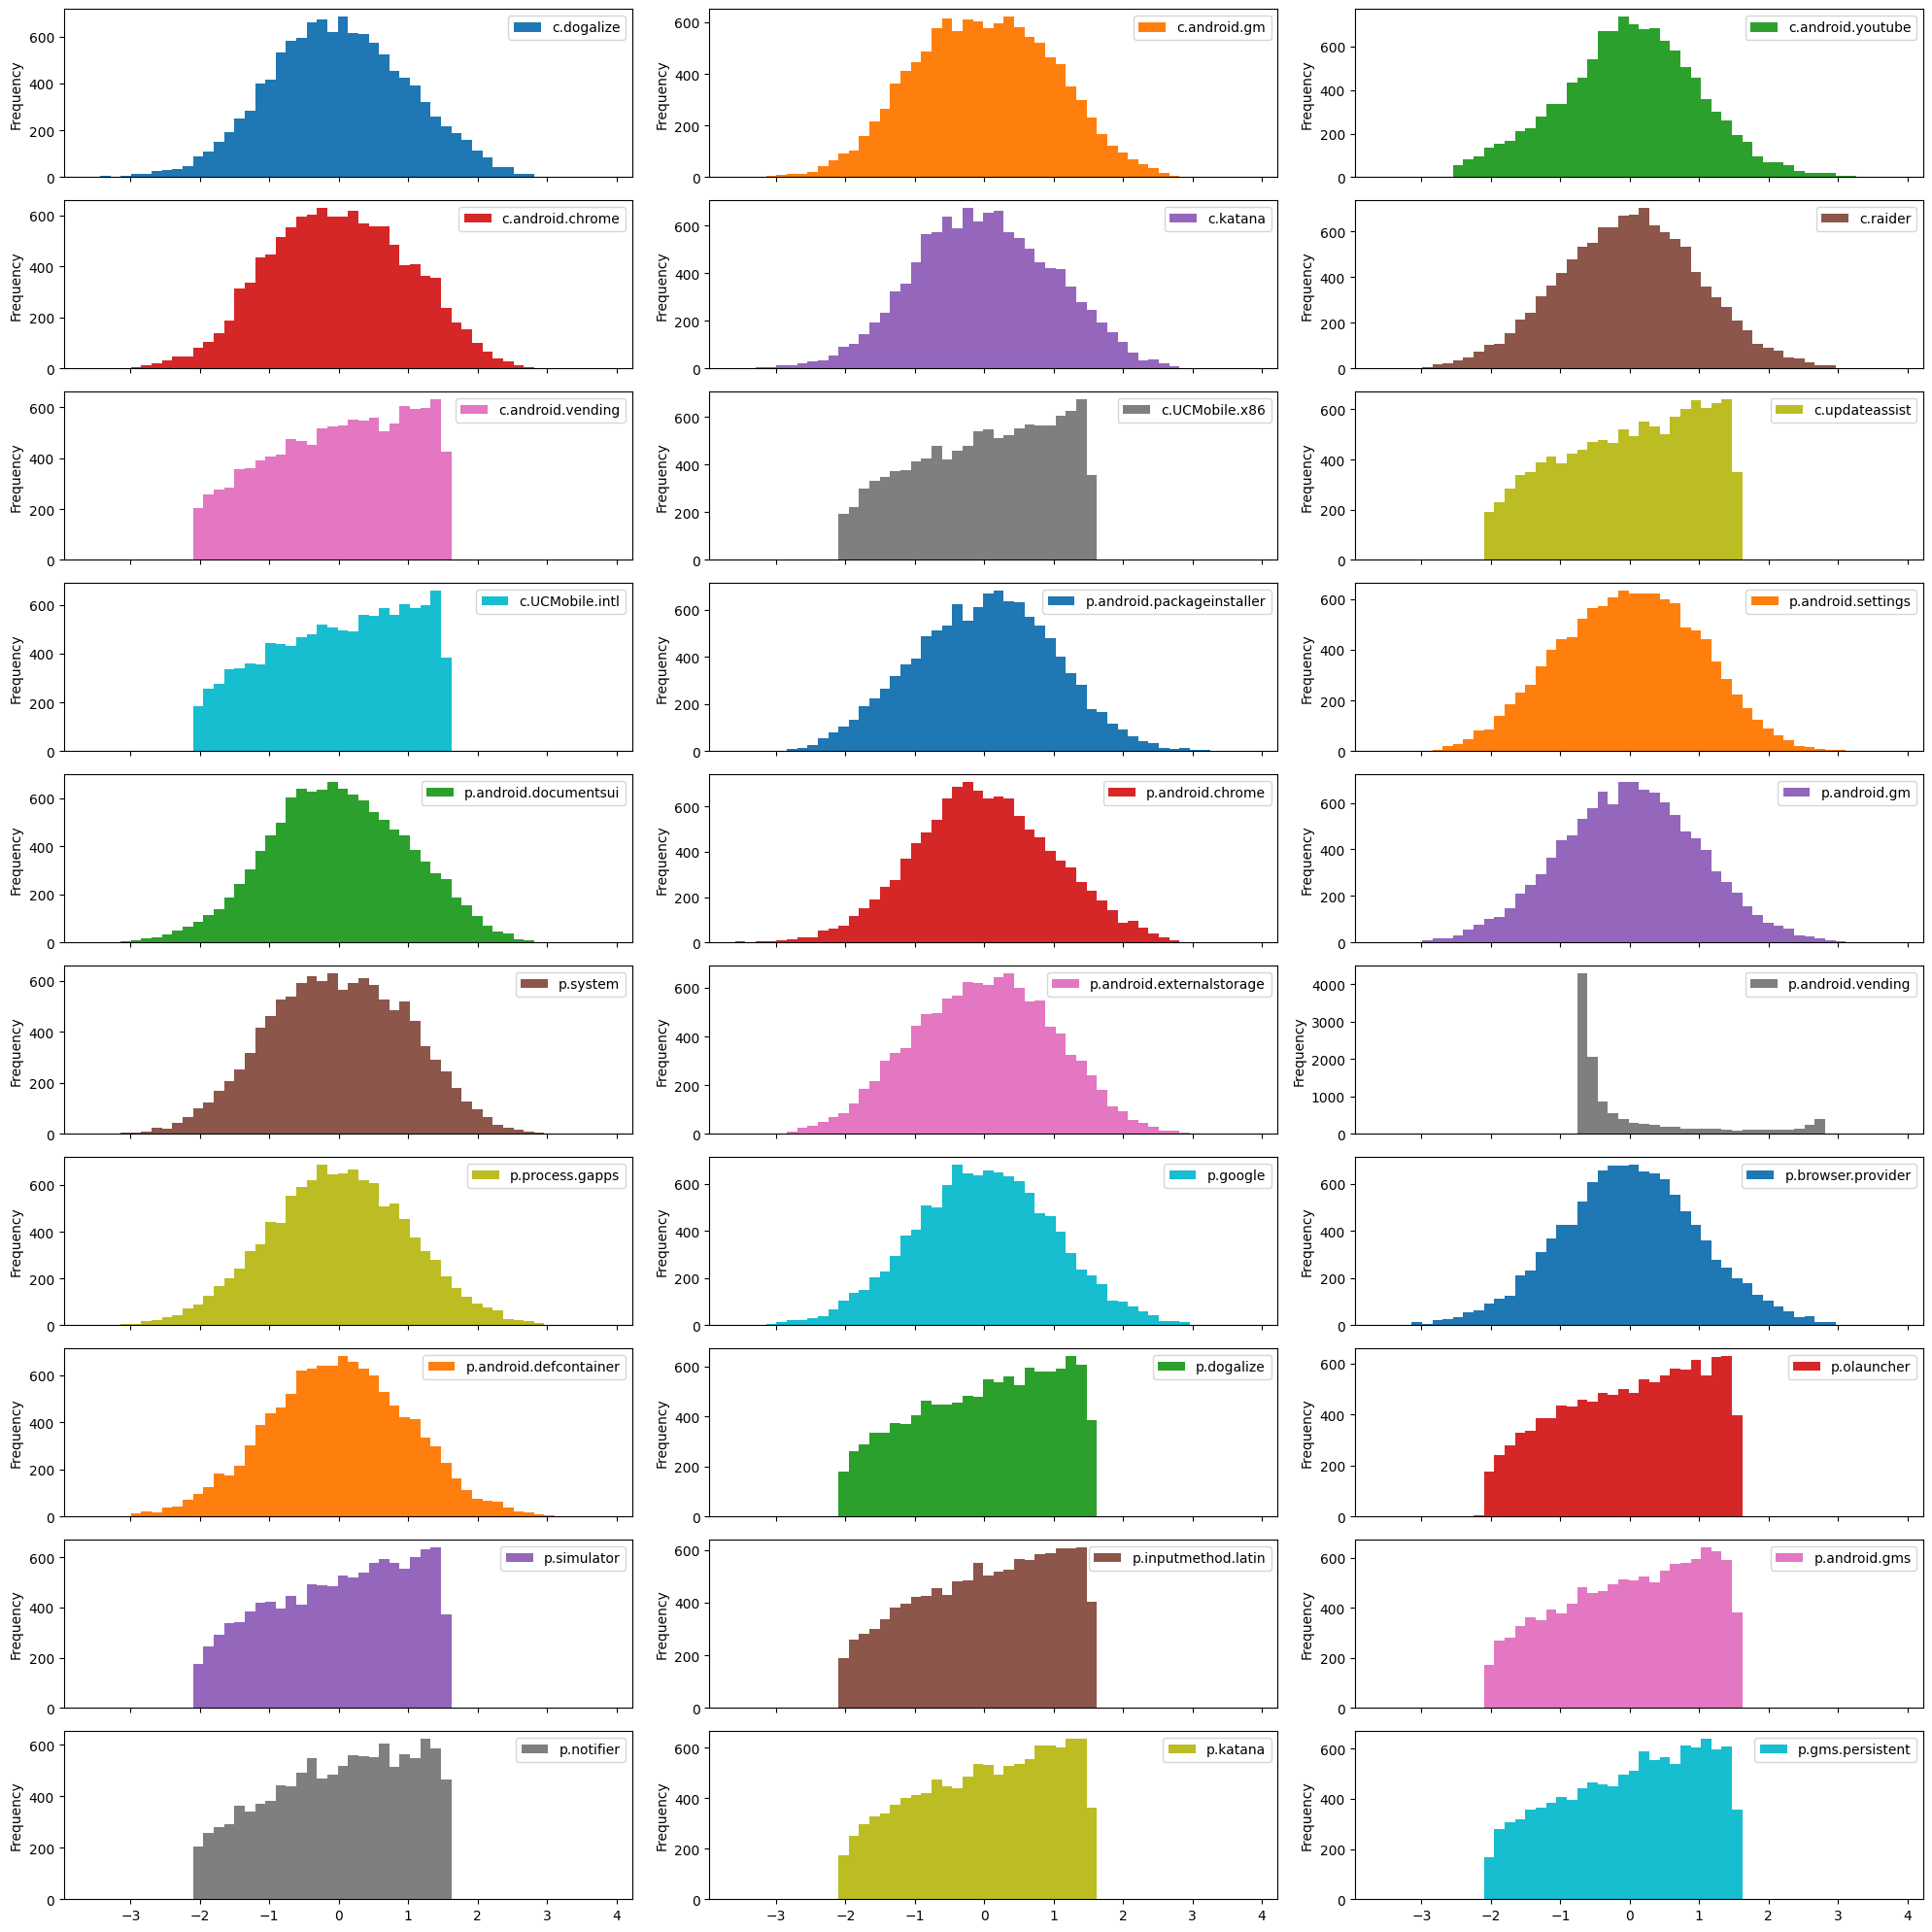

In [31]:
# Define scaler and transformer
scaler = StandardScaler()
power_transformer = PowerTransformer(method="yeo-johnson")

normalized_data = X.copy()

# Transform data using PowerTransformer
normalized_data[all_columns] = power_transformer.fit_transform(normalized_data[all_columns])

# Scale data using StandardScaler
normalized_data[all_columns] = scaler.fit_transform(normalized_data[all_columns])

# Plot histograms
normalized_data.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

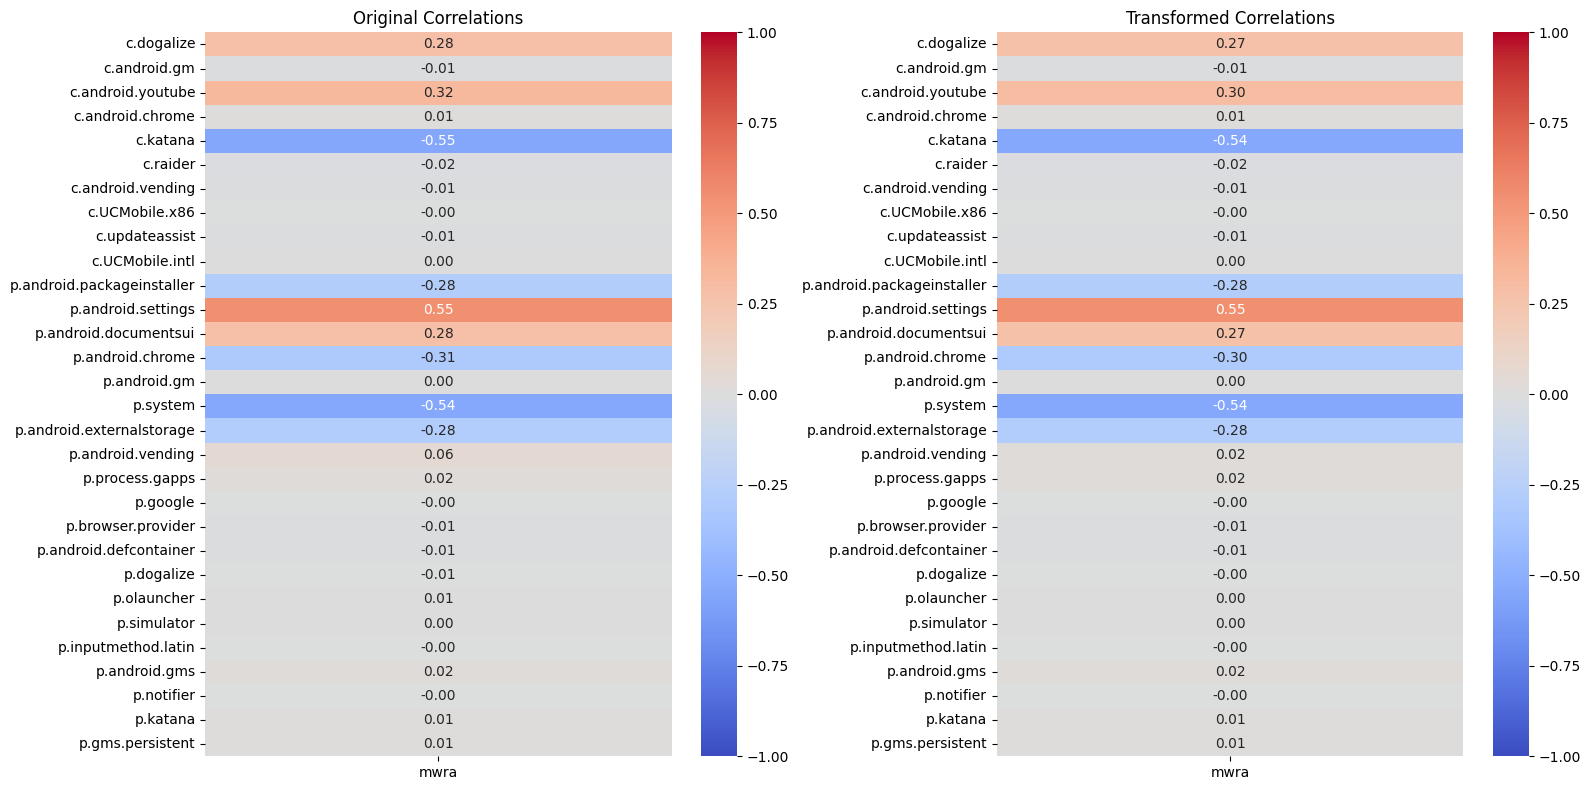

In [32]:
feature_columns = normalized_data.columns.tolist()

# Original correlations
combined_df_orig = pd.concat([X, train_data["mwra"]], axis=1).dropna()
corr_orig = combined_df_orig.corr(method="pearson")
filtered_corr_orig = corr_orig.loc[feature_columns, ["mwra"]]

# Transformed correlations
combined_df_trans = pd.concat([normalized_data, train_data["mwra"]], axis=1).dropna()
corr_trans = combined_df_trans.corr(method="pearson")
filtered_corr_trans = corr_trans.loc[feature_columns, ["mwra"]]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot original correlations
sns.heatmap(
    filtered_corr_orig,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax1,
)
ax1.set_title("Original Correlations")

# Plot transformed correlations
sns.heatmap(
    filtered_corr_trans,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax2,
)
ax2.set_title("Transformed Correlations")

plt.tight_layout()
plt.show()

### Final Transformation


-   First using StandardScaler then PowerTransformer on all columns similar to gaussian distribution
-   Then using QuantileTransformer on all other columns


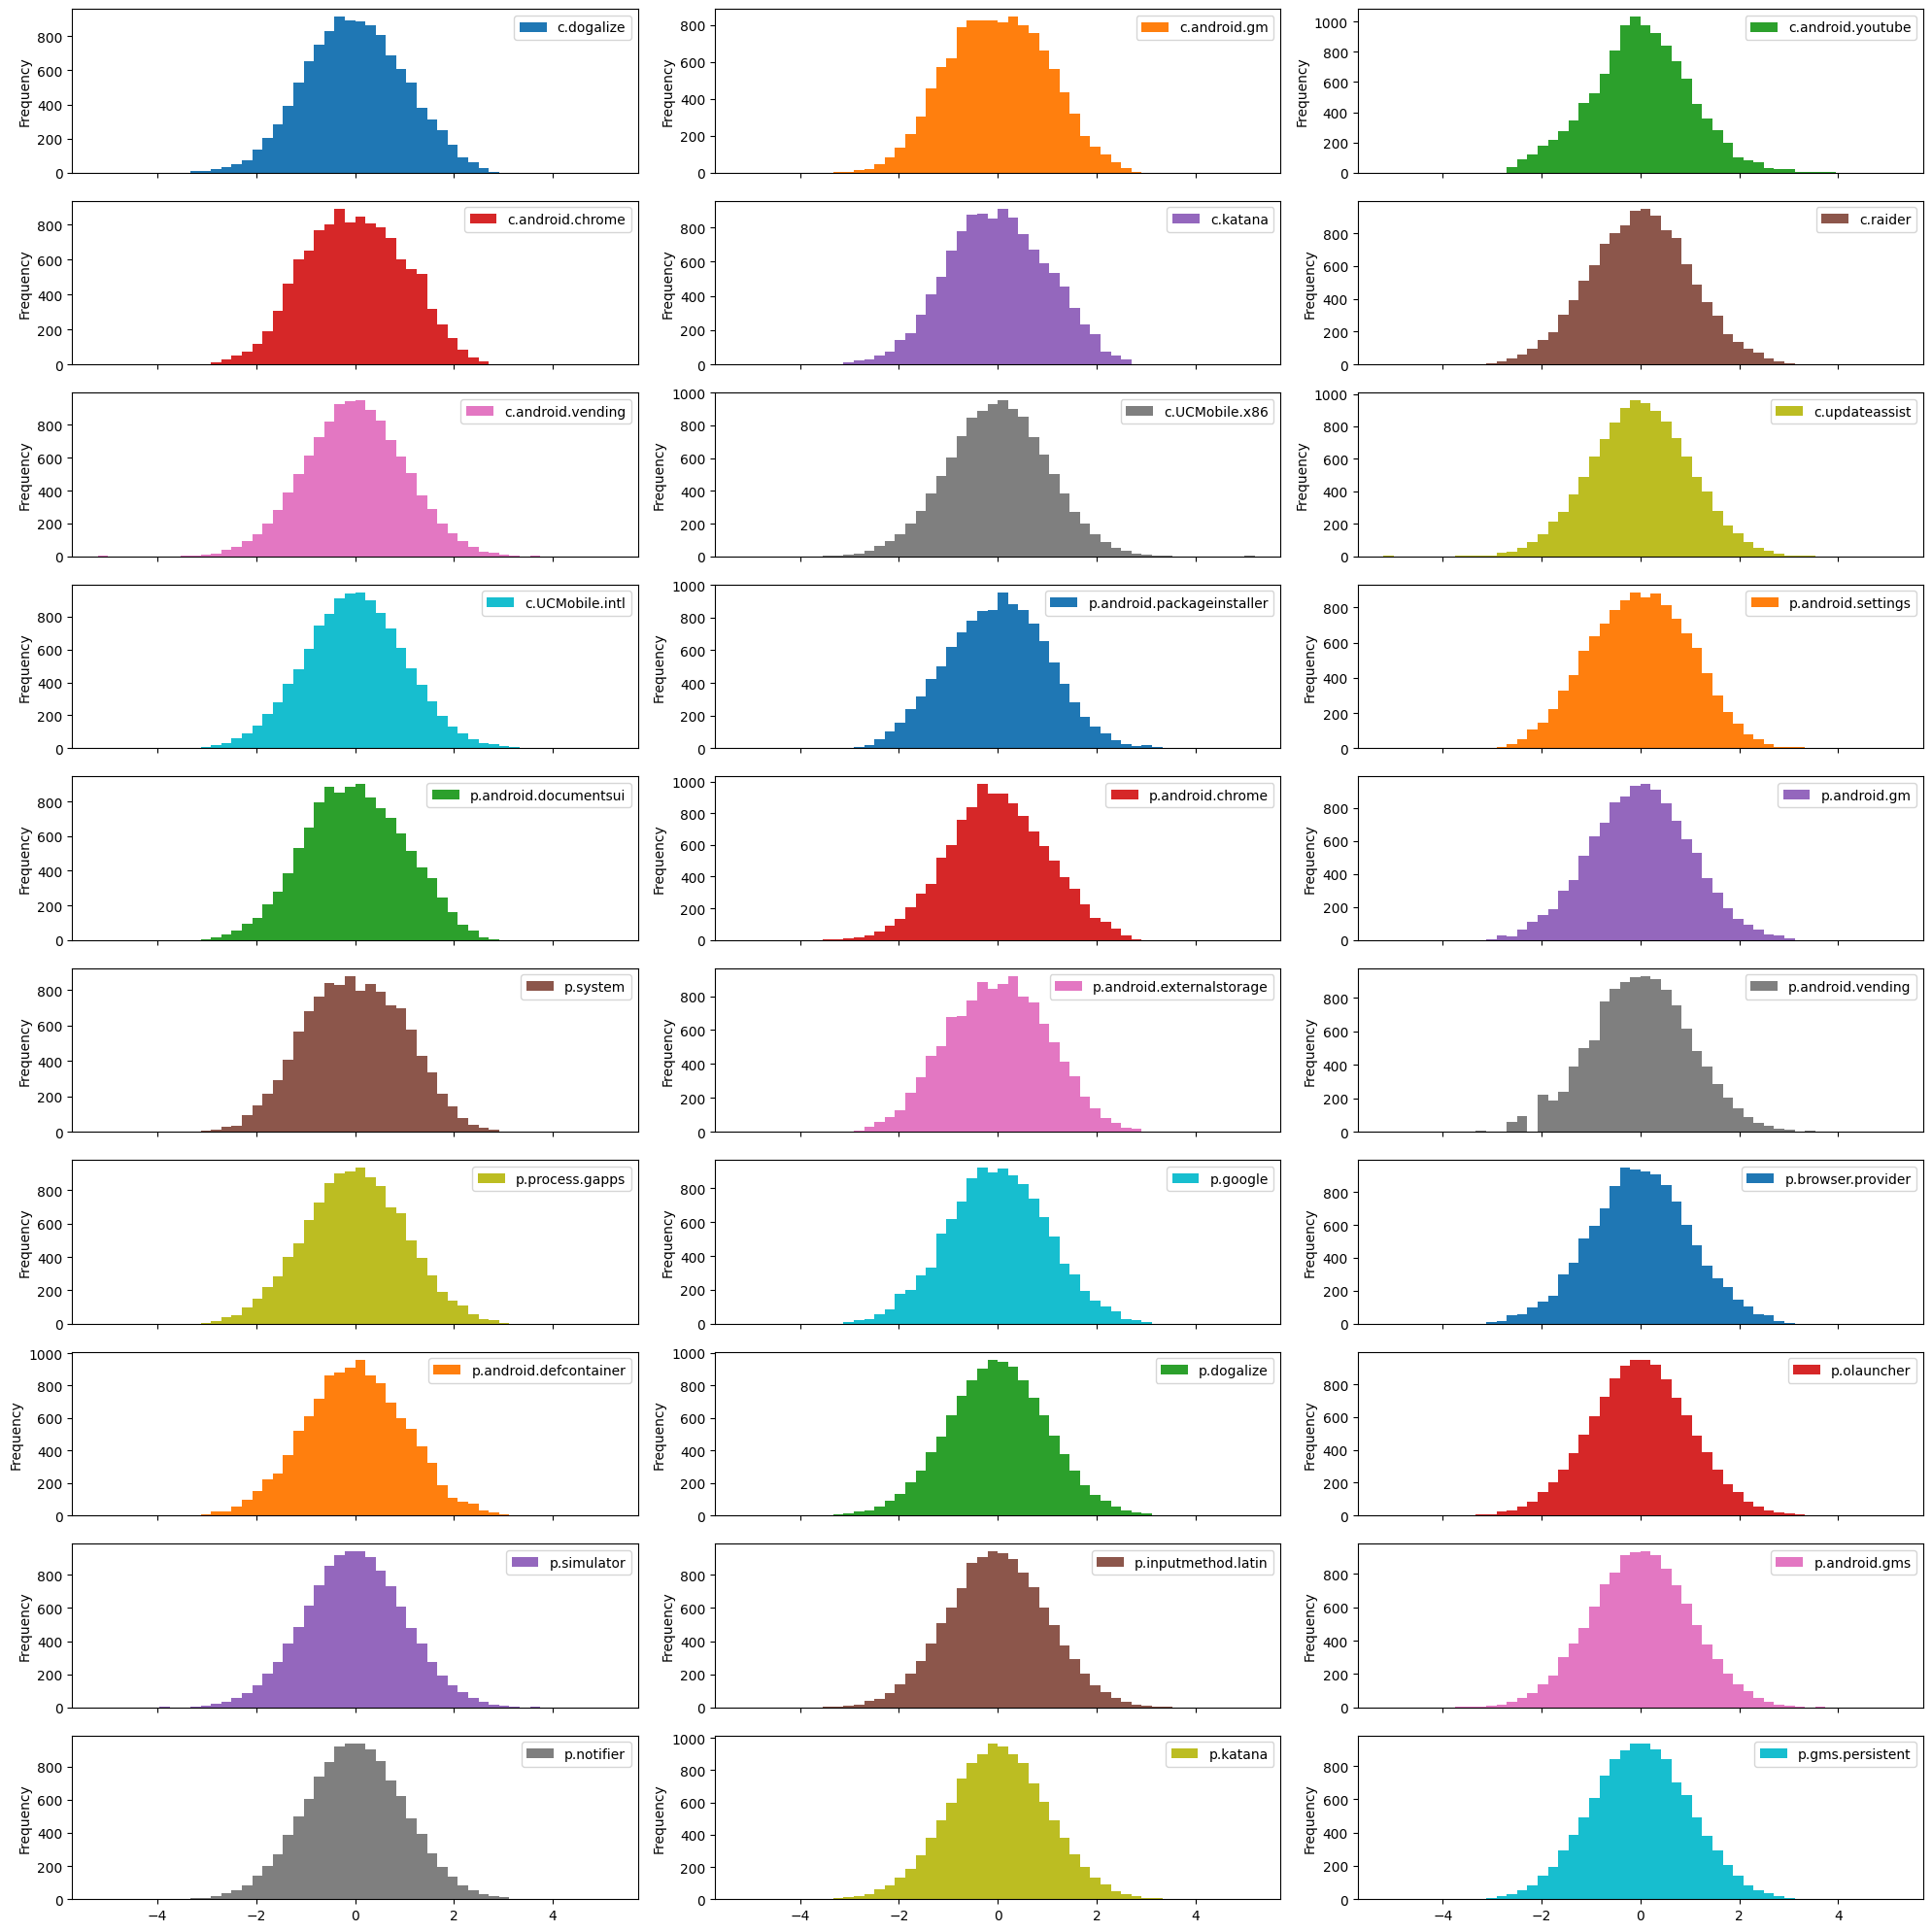

In [33]:
# Define columns
all_columns = X.columns
vending_column = ["p.android.vending"]
uniform_columns = [
    "c.android.vending",
    "c.UCMobile.x86",
    "c.updateassist",
    "c.UCMobile.intl",
    "p.dogalize",
    "p.olauncher",
    "p.simulator",
    "p.inputmethod.latin",
    "p.android.gms",
    "p.notifier",
    "p.katana",
    "p.gms.persistent",
]
non_gaussian_columns = vending_column + uniform_columns
gaussian_columns = all_columns[~all_columns.isin(non_gaussian_columns)]

# Define scaler and transformers
scaler = StandardScaler()
power_transformer = PowerTransformer(method="yeo-johnson")
quantile_transformer = QuantileTransformer(output_distribution="normal", random_state=42)

# Normalize data (general columns)
normalized_data = X.copy()
normalized_data[gaussian_columns] = scaler.fit_transform(normalized_data[gaussian_columns])
normalized_data[gaussian_columns] = power_transformer.fit_transform(normalized_data[gaussian_columns])

# Normalize data (vending column)
normalized_data[non_gaussian_columns] = quantile_transformer.fit_transform(normalized_data[non_gaussian_columns])

# Plot histograms
normalized_data.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

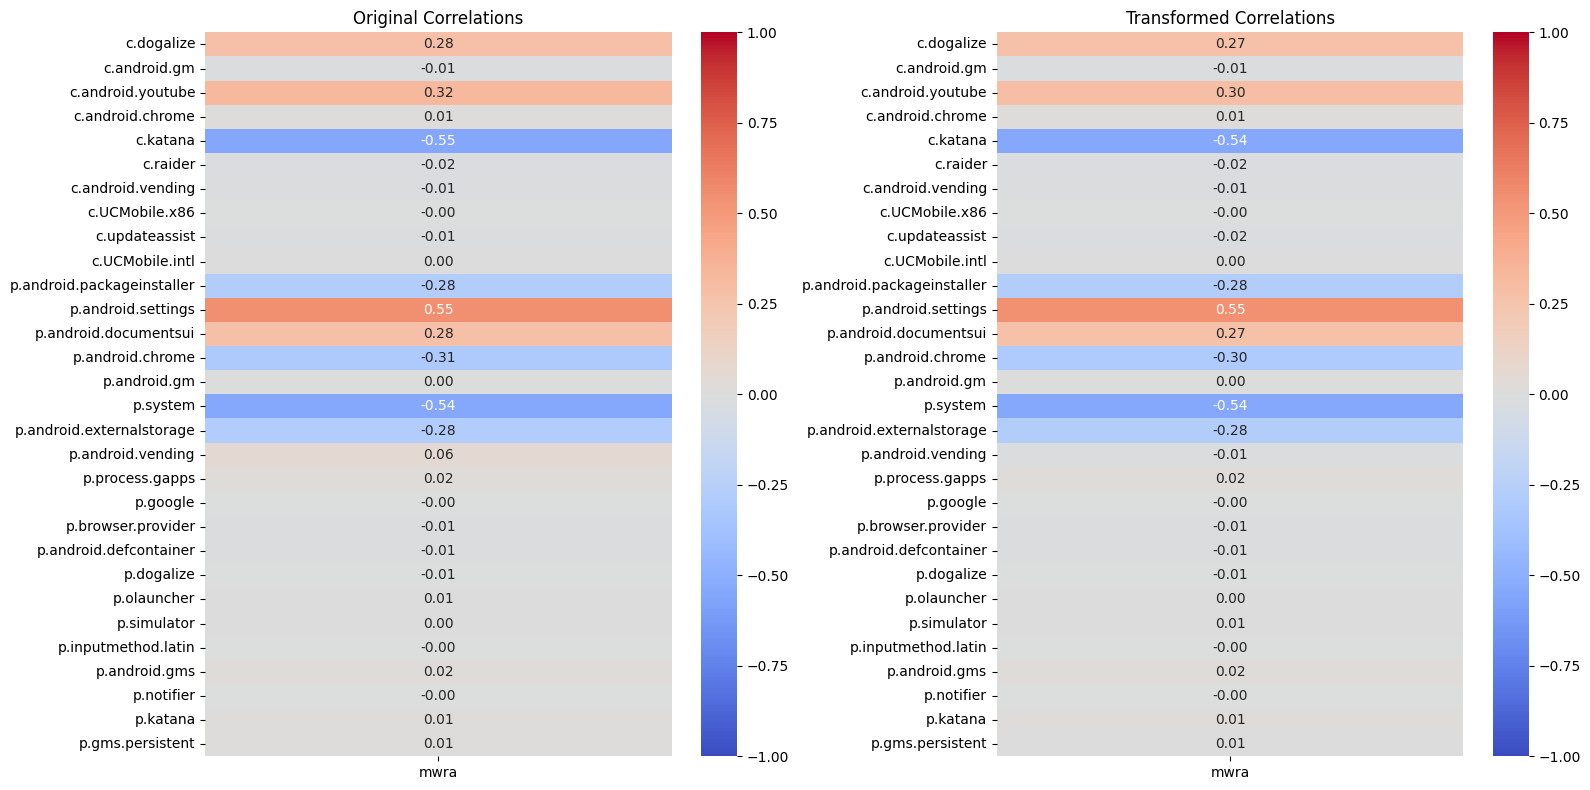

In [34]:
feature_columns = normalized_data.columns.tolist()

# Original correlations
combined_df_orig = pd.concat([X, train_data["mwra"]], axis=1).dropna()
corr_orig = combined_df_orig.corr(method="pearson")
filtered_corr_orig = corr_orig.loc[feature_columns, ["mwra"]]

# Transformed correlations
combined_df_trans = pd.concat([normalized_data, train_data["mwra"]], axis=1).dropna()
corr_trans = combined_df_trans.corr(method="pearson")
filtered_corr_trans = corr_trans.loc[feature_columns, ["mwra"]]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot original correlations
sns.heatmap(
    filtered_corr_orig,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax1,
)
ax1.set_title("Original Correlations")

# Plot transformed correlations
sns.heatmap(
    filtered_corr_trans,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    xticklabels=["mwra"],
    yticklabels=feature_columns,
    ax=ax2,
)
ax2.set_title("Transformed Correlations")

plt.tight_layout()
plt.show()

We are going to use this transformation in the next steps for feature selection.


In [35]:
X = normalized_data.copy()

## D


### **Zadanie:** Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)


In previous sections we have gathered these insights:

-   Scaling:
    -   We identified need for scaling data, because data has different ranges
    -   Min-Max Scaling showed promising results, when not combining with anything else
    -   Standard Scaler showed also promising results, the only problem was column **'p.android.vending'** as it has too big range and many outliers (we used Z-score(3), maybe using quantile detection could improved this), the scaled graph also showed outliers
-   Transformers:
    -   Power Transformer didn't show that promising results for uniform graphs (it made the a little logarithmic), but promising results for normal graphs
    -   Quantile Transformer transforms data to perfect normal distribution, but it could distort linear correlations
-   Combinations:
    -   Using Min-Max Scaler and Power Transformer showed promising results, as it transform data to normal distributions and also kept uniform distributions (didn't make them logarithmic, but there is some very slight logarithmic effect)
    -   Using Standard Scaler and Power Transformer showed even more promising results compared to Using Min-Max Scaler and Power Transformer, as it transform data to normal distributions and also kept uniform distributions without any logarithmic effect
-   Final choice:

    -   First using StandardScaler then PowerTransformer on all columns similar to gaussian distribution
    -   Then using QuantileTransformer on all other columns

-   Correlations remains similar using all transformations


# 2.2


## A

### **Zadanie:** Zistite, ktoré atribúty (features) vo vašich dátach pre ML sú informatívne k predikovanej premennej (minimálne 3 techniky s porovnaním medzi sebou).


### Variance Threshold


In [36]:
selector = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
selector.fit(X)
support_mask = selector.get_support()

removed_columns = X.columns[~support_mask].tolist()

print("Removed columns:", removed_columns)

Removed columns: []


In [37]:
variance_threshold_data = X

thresholds = np.arange(0.0, 1, 0.05)
results = list()
for t in thresholds:
    transform = VarianceThreshold(threshold=t)
    tmp = transform.fit_transform(variance_threshold_data)
    n_features = tmp.shape[1]
    print(">Threshold=%.2f, Features=%d" % (t, n_features))
    results.append(n_features)

>Threshold=0.00, Features=30
>Threshold=0.05, Features=30
>Threshold=0.10, Features=30
>Threshold=0.15, Features=30
>Threshold=0.20, Features=30
>Threshold=0.25, Features=30
>Threshold=0.30, Features=30
>Threshold=0.35, Features=30
>Threshold=0.40, Features=30
>Threshold=0.45, Features=30
>Threshold=0.50, Features=30
>Threshold=0.55, Features=30
>Threshold=0.60, Features=30
>Threshold=0.65, Features=30
>Threshold=0.70, Features=30
>Threshold=0.75, Features=30
>Threshold=0.80, Features=30
>Threshold=0.85, Features=30
>Threshold=0.90, Features=30
>Threshold=0.95, Features=30


-   We see different threshold values have no effect on the results


### Mutual Information


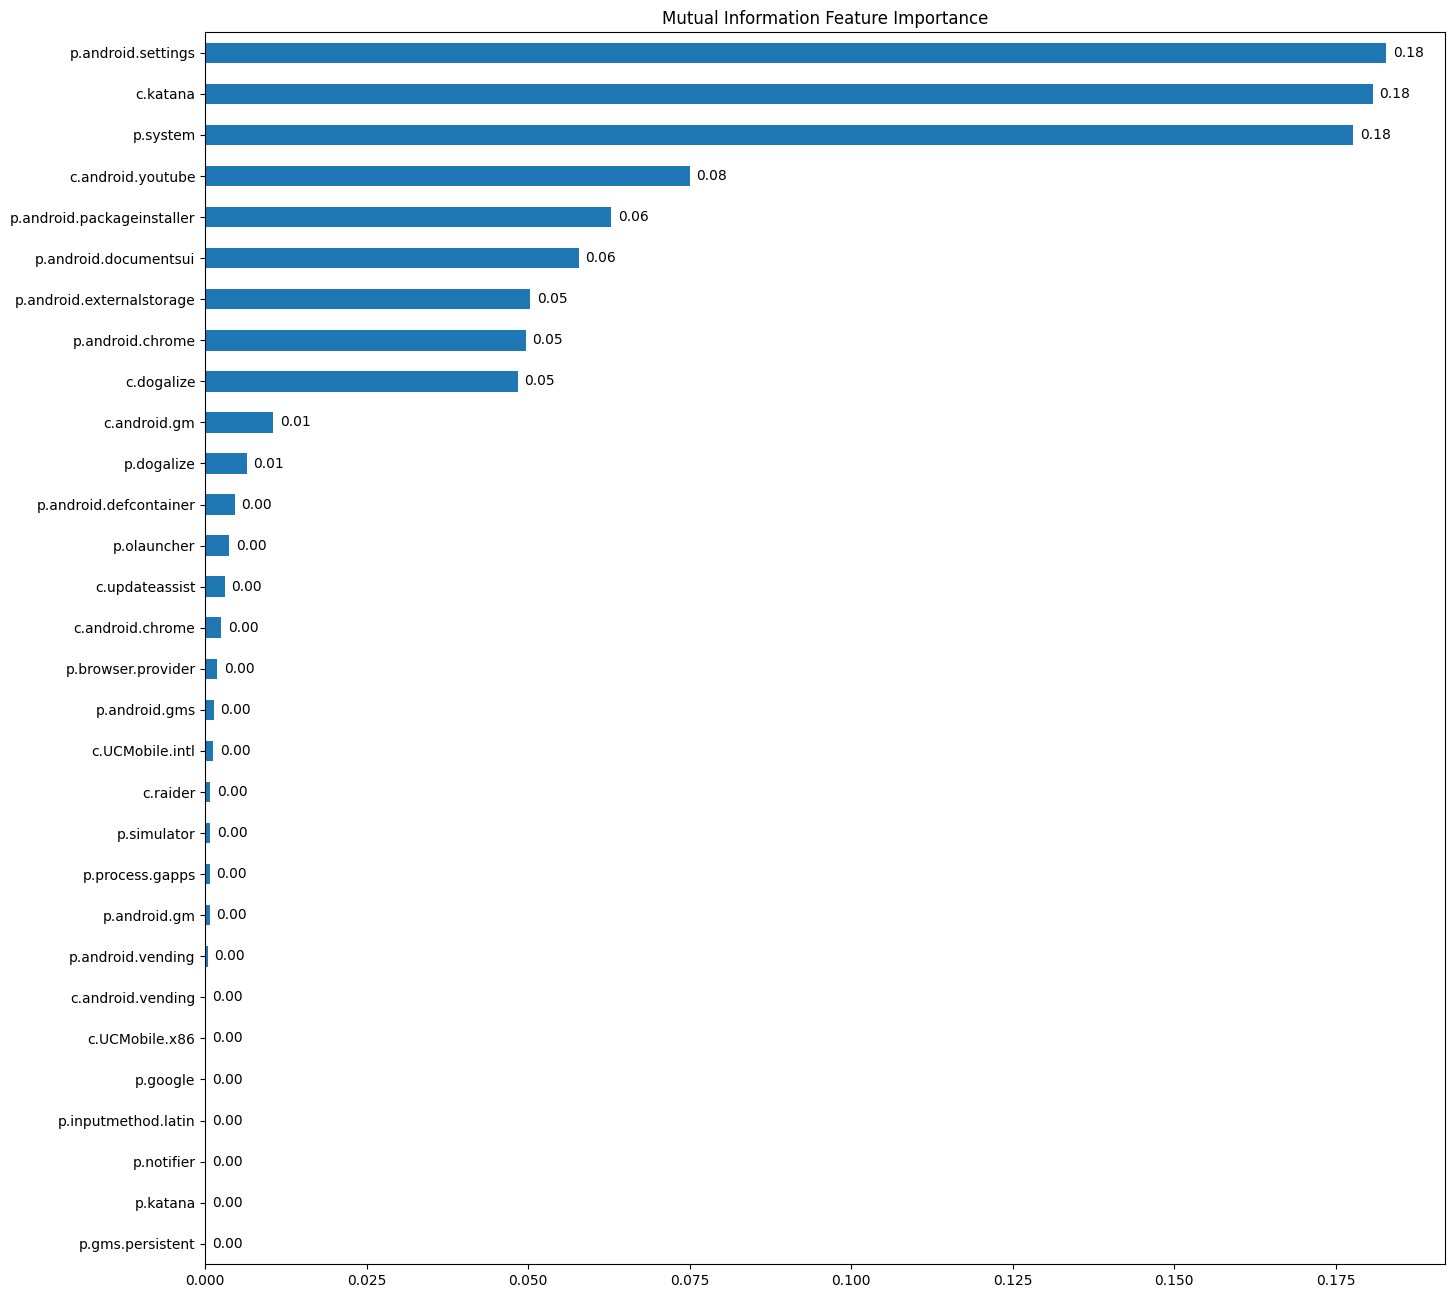

In [38]:
selector = mutual_info_classif(X, y)
importance = pd.Series(selector, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(16, 16))
ax = importance.plot(kind="barh")

for i, v in enumerate(importance):
    ax.text(v + 0.001, i, f"{v:.2f}", va="center")

plt.gca().invert_yaxis()
plt.title("Mutual Information Feature Importance")
plt.show()

In [39]:
selector = mutual_info_classif(X, y)
importance = pd.Series(selector, index=X.columns).sort_values(ascending=False)
importance = importance[importance > 0.05]

importance = pd.DataFrame(importance)
importance

,0
p.android.settings,0.182671
c.katana,0.180482
p.system,0.177643
c.android.youtube,0.075057
p.android.packageinstaller,0.062847
p.android.documentsui,0.057775
p.android.externalstorage,0.050015


-   We got these features as best:
    -   **p.android.settings**, **c.katana**, **p.system**, **c.android.youtube**, **p.android.packageinstaller**, **p.android.documentsui**, **p.android.externalstorage**


### F Statistic


-   Our target variable **mwra** could be specified as categorical (True, False), so we are gonna try this method


Selecting K-best (k=7) features using F-statistic


In [40]:
selector = SelectKBest(score_func=f_classif, k=7)
_ = selector.fit_transform(X, y)
mask = selector.get_support()

selected_columns = X.columns[mask]
importance = selector.scores_[mask]

selected_features = pd.DataFrame({"Feature": selected_columns, "Importance": importance})

sorted_features = selected_features.sort_values(by="Importance", ascending=False).reset_index(drop=True)
sorted_features

,Feature,Importance
0,p.android.settings,4883.486630
1,c.katana,4803.387327
2,p.system,4768.452771
3,p.android.chrome,1120.597758
4,c.android.youtube,1106.695598
5,p.android.externalstorage,983.902185
6,p.android.packageinstaller,939.850134


-   We got these features as best:
    -   **p.android.settings**, **c.katana**, **p.system**, **c.android.youtube**, **p.android.chrome**, **p.android.externalstorage**, **p.android.packageinstaller**
-   We see different features and it's importance compared to previous tests


### SelectFromModel


In [41]:
selector = SelectFromModel(estimator=LogisticRegression(max_iter=1000, random_state=42))
_ = selector.fit_transform(X, y)

mask = selector.get_support()
selected_columns = X.columns[mask]
importance = np.abs(selector.estimator_.coef_[0][mask])

selected_features = pd.DataFrame({"Feature": selected_columns, "Importance": importance})
sorted_features = selected_features.sort_values(by="Importance", ascending=False).reset_index(drop=True)

sorted_features

,Feature,Importance
0,c.katana,1.052042
1,p.system,0.983599
2,p.android.settings,0.960388
3,c.android.youtube,0.288707
4,p.android.externalstorage,0.263946
5,c.dogalize,0.215547
6,p.android.vending,0.164101


In [42]:
selector = SelectFromModel(estimator=LinearSVC(random_state=42))
_ = selector.fit_transform(X, y)

mask = selector.get_support()
selected_columns = X.columns[mask]
importance = np.abs(selector.estimator_.coef_[0][mask])

selected_features = pd.DataFrame({"Feature": selected_columns, "Importance": importance})
selected_features = selected_features.sort_values(by="Importance", ascending=False).reset_index(drop=True)

selected_features

,Feature,Importance
0,c.katana,0.337239
1,p.system,0.326265
2,p.android.settings,0.324639
3,p.android.externalstorage,0.090803
4,c.android.youtube,0.086843
5,c.dogalize,0.079847


In [43]:
model = SelectFromModel(estimator=RandomForestClassifier(random_state=42))
_ = model.fit_transform(X, y)

selected_columns = X.columns[model.get_support()]
importance = model.estimator_.feature_importances_

selected_features = pd.DataFrame({"Feature": selected_columns, "Importance": importance[model.get_support()]})
selected_features = selected_features.sort_values(by="Importance", ascending=False).reset_index(drop=True)

selected_features

,Feature,Importance
0,c.katana,0.155428
1,p.android.settings,0.154494
2,p.system,0.144161
3,c.android.youtube,0.066945
4,p.android.chrome,0.047081
5,c.dogalize,0.046287
6,p.android.packageinstaller,0.041603
7,p.android.externalstorage,0.036860


## B

### **Zadanie:** Zoraďte zistené atribúty v poradí podľa dôležitosti.


-   Sorted in previous step


## C

### **Zadanie:** Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu (t.j. zdokumentovanie)


-   We see that different methods also selects different features with different importance
-   We are going to try to use SelectKBest, with f_classif, but we will try different models and see how they perform later when we have ML


# 2.3


## Exporting raw data

Removing duplicated and outliers.
Data is split into train and test datasets.


-   Removing outliers using iterative Z-score(3) method. (until there are no outliers, max iteration is 10)


In [44]:
import os

import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

### Loading and merging dataset


In [45]:
file_path: str = "../data/raw"
files: tuple[str, ...] = ("connections", "devices", "processes", "profiles")

dataset: dict[str, pd.DataFrame] = {}
for file in files:
    dataset[file] = pd.read_csv(f"{file_path}/{file}.csv", sep="\t")
    dataset[file] = dataset[file].drop_duplicates()

In [46]:
df = pd.merge(dataset["connections"], dataset["processes"], on=["imei", "ts", "mwra"])
df["ts"] = pd.to_datetime(df.ts)

### Splitting dataset


In [47]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

### Clearing outliers


In [48]:
number_of_rows_before_outliers = train_data.shape[0]
# 1 iteration of cleaning whole dataset of outliers (including p.android.vending)
train_data = train_data[(np.abs(zscore(train_data.iloc[:, 3:])) < 3).all(axis=1)]

# Using all columns except c.android.vending for outlier detection
columns_for_zscore = train_data.iloc[:, 3:].columns.difference(["p.android.vending"])
outliers_count = (~(np.abs(zscore(train_data[columns_for_zscore])) < 3).all(axis=1)).sum()
max_iterations = 10
iteration = 0

# Iterating after we removed all outliers
while outliers_count > 0:
    train_data = train_data[(np.abs(zscore(train_data[columns_for_zscore])) < 3).all(axis=1)]
    outliers_count = (~(np.abs(zscore(train_data[columns_for_zscore])) < 3).all(axis=1)).sum()
    iteration += 1
    if iteration >= max_iterations:
        break

train_data = train_data.reset_index(drop=True)

number_of_rows_after_outliers = train_data.shape[0]
print(f"Number of removed outliers: {number_of_rows_before_outliers - number_of_rows_after_outliers}")
print(
    f"Percentage of removed outliers: {(number_of_rows_before_outliers - number_of_rows_after_outliers) / number_of_rows_before_outliers * 100:.2f}%"
)

Number of removed outliers: 570
Percentage of removed outliers: 4.77%


-   We are not removing outliers from **"p.android.vending"**, as it has logarithmic scale and therefore many outliers
-   We removed 570 (4.77%) rows using iterative Z-score(3) method. So using this method is ok as it doesn't remove too many rows


### Exporting to cleaned data .cvs


In [49]:
import os

os.makedirs("../data/clean", exist_ok=True)

train_data.to_csv("../data/clean/train_data.csv", index=False)
test_data.to_csv("../data/clean/test_data.csv", index=False)

## A

### **Zadanie:** Upravte váš kód realizujúci predspracovanie trénovacej množiny tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny v kontexte strojového učenia.


In [50]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

### Loading clean data


In [51]:
train_data = pd.read_csv("../data/clean/train_data.csv")
test_data = pd.read_csv("../data/clean/test_data.csv")

### Define feature column lists


In [52]:
all_columns = train_data.drop(columns=["mwra", "ts", "imei"]).columns
non_gaussian_columns = [
    "c.android.vending",
    "c.UCMobile.x86",
    "c.updateassist",
    "c.UCMobile.intl",
    "p.android.vending",
    "p.dogalize",
    "p.olauncher",
    "p.simulator",
    "p.inputmethod.latin",
    "p.android.gms",
    "p.notifier",
    "p.katana",
    "p.gms.persistent",
]
gaussian_columns = all_columns[~all_columns.isin(non_gaussian_columns)]
transformed_feature_order = pd.Series(gaussian_columns.tolist() + non_gaussian_columns)

### Defining pipeline


In [57]:
# Create preprocessing pipelines
from sklearn.preprocessing import RobustScaler

general_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("power_transformer", PowerTransformer(method="yeo-johnson")),
    ]
)

vending_pipeline = Pipeline(
    [
        ("quantile_transformer", QuantileTransformer(output_distribution="normal", random_state=42)),
    ]
)

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("general", general_pipe, gaussian_columns),
        ("vending", vending_pipeline, non_gaussian_columns),
    ],
    remainder="passthrough",
)

# Create complete pipeline
complete_pipeline = Pipeline([("preprocessor", preprocessor), ("selector", SelectKBest(f_classif, k=3))])

### Using pipeline


In [58]:
# Fit and transform training data, transform test data
X_train_processed = complete_pipeline.fit_transform(train_data[feature_columns], train_data["mwra"])
X_test_processed = complete_pipeline.transform(test_data[feature_columns])

# Get selected features immediately after fitting
feature_mask = complete_pipeline.named_steps["selector"].get_support()
selected_features = transformed_feature_order[feature_mask]  # order of features is preserved

# Create DataFrames with selected feature names
X_train_processed = pd.DataFrame(X_train_processed, columns=selected_features)
X_test_processed = pd.DataFrame(X_test_processed, columns=selected_features)

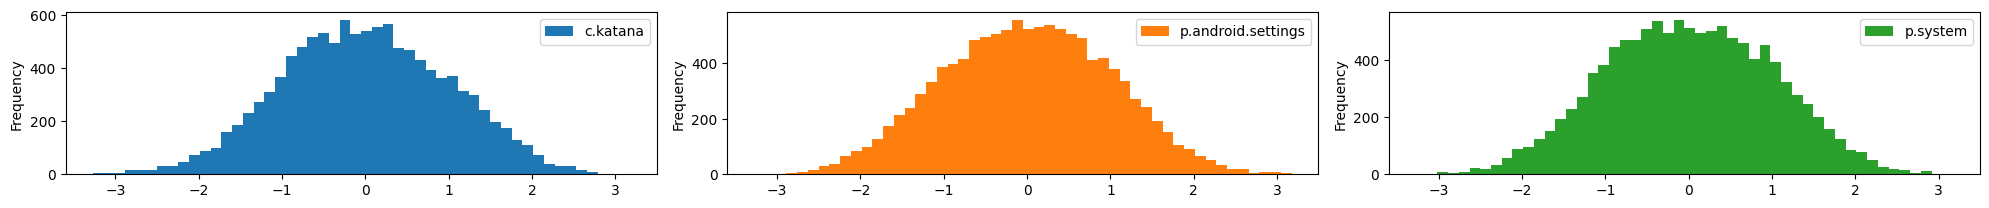

In [59]:
X_train_processed.plot(kind="hist", bins=50, figsize=(20, 20), subplots=True, layout=(10, 3))
plt.tight_layout()
plt.show()

### Exporting processed data to .cvs


In [56]:
os.makedirs("../data/processed", exist_ok=True)

X_train_processed.to_csv("../data/processed/train_data.csv", index=False)
X_test_processed.to_csv("../data/processed/test_data.csv", index=False)

## B

### **Zadanie:** Využite možnosti sklearn.pipeline


-   In previous steps we have already used pipelines
